# TODO

- you need plots


In [1]:
import numpy as np
import pandas as pd
import pickle
import statsmodels.api as sm
from linearmodels.panel import PanelOLS

import matplotlib.pyplot as plt

In [2]:
data_dir = '/home/simon/Documents/Bodies/data/done_dfs/'

with open(f'{data_dir}bodies_df_2022_v1_2.pkl', 'rb') as file:
    bodies_df = pickle.load(file)

In [56]:
# pre

list_of_features_mean = [feature for feature in bodies_df.columns if 'mean' in feature] 
list_of_ra_features = [feature for feature in bodies_df.columns if 'all' in feature] 

list_of_features = list_of_features_mean + list_of_ra_features

df_sub = bodies_df[list_of_features + ['log_best', 'tce', 'tsce', 'publication', 'month_id', 'gid']].copy()
df_sub = df_sub[df_sub['person_mean'] != 0] # no people, no entry
df_sub[['Published', 'Raw', 'Submitted']] = pd.get_dummies(df_sub[['publication']])

# indtil det er styr på det her:
df_sub = df_sub[df_sub['Published'] == 0]

df_sub.drop(columns= 'publication', inplace= True)
df_sub.dropna(inplace= True)


# for FE
df_sub.set_index(['gid', 'month_id'], inplace = True)

#df_sub['intPubBest'] = df_sub['Published'] * df_sub['log_best']
#df_sub['intPubTce'] = df_sub['Published'] * df_sub['tce']
#df_sub['intPubTsce'] = df_sub['Published'] * df_sub['tsce']

df_sub['intMilFem'] = df_sub['female_mean'] * df_sub['all_militarized']
df_sub['intMilGar'] = df_sub['religiousGarmentFemale_mean'] * df_sub['all_militarized']


df_sub['intUnFem'] = df_sub['female_mean'] * df_sub['uniformed_mean']
df_sub['intUnGar'] = df_sub['religiousGarmentFemale_mean'] * df_sub['uniformed_mean']

df_sub['intFemGar'] = df_sub['female_mean'] * df_sub['uniformed_mean']

df_sub['intFemPub'] = df_sub['female_mean'] * df_sub['all_public']
df_sub['intFemPri'] = df_sub['female_mean'] * df_sub['all_privat']


df_sub['person_dummy'] = (df_sub['person_mean'] >= 1) * 1
df_sub['female_dummy'] = (df_sub['female_mean']>= 1) * 1
df_sub['religiousGarmentFemale_dummy'] = (df_sub['religiousGarmentFemale_mean'] >= 1) * 1



# df_sub['person_dummy'] = (df_sub['person_mean'] > 0) * 1
# df_sub['female_dummy'] = (df_sub['female_mean']> 0) * 1
# df_sub['religiousGarmentFemale_dummy'] = (df_sub['religiousGarmentFemale_mean'] > 0) * 1


df_sub['firearm_dummy'] = (df_sub['firearm_mean'] >= 1) * 1
df_sub['uniformed_dummy'] = (df_sub['uniformed_mean'] >= 1) * 1
df_sub['militaryVehicle_dummy'] = (df_sub['militaryVehicle_mean'] >= 1) * 1
df_sub['falgIRQ_dummy'] = (df_sub['falgIRQ_mean'] >= 1) * 1
df_sub['flagUS_dummy'] = (df_sub['flagUS_mean'] >= 1) * 1


df_sub['intMilDFem'] = df_sub['female_dummy'] * df_sub['all_militarized']
df_sub['intMilDGar'] = df_sub['religiousGarmentFemale_dummy'] * df_sub['all_militarized']


df_sub['intDFirDFem'] = df_sub['female_dummy'] * df_sub['firearm_dummy']
df_sub['intDFirDGar'] = df_sub['religiousGarmentFemale_dummy'] * df_sub['firearm_dummy']


df_sub['intDUniDFem'] = df_sub['female_dummy'] * df_sub['uniformed_dummy']
df_sub['intDUniDGar'] = df_sub['religiousGarmentFemale_dummy'] * df_sub['uniformed_dummy']



df_sub['intFemDPub'] = df_sub['female_dummy'] * df_sub['all_public']
df_sub['intFemDPri'] = df_sub['female_dummy'] * df_sub['all_privat']




In [4]:
df_sub.columns

Index(['person_mean', 'child_mean', 'male_mean', 'adult_mean', 'youth_mean',
       'falgIRQ_mean', 'female_mean', 'religiousGarmentFemale_mean',
       'uniformed_mean', 'firearm_mean', 'flagUS_mean', 'bloodedArea_mean',
       'militaryVehicle_mean', 'hostage_mean', 'casualty_mean', 'elderly_mean',
       'nlights_calib_mean', 'nlights_mean', 'nlights_calib_mean_observed',
       'nlights_mean_observed', 'cmr_mean', 'imr_mean', 'mountains_mean',
       'ttime_mean', 'all_rural', 'all_formal', 'all_public',
       'all_militarized', 'all_urban', 'all_privat', 'log_best', 'tce', 'tsce',
       'Published', 'Raw', 'Submitted', 'intMilFem', 'intMilGar', 'intUnFem',
       'intUnGar', 'intFemGar', 'intFemPub', 'intFemPri', 'person_dummy',
       'female_dummy', 'religiousGarmentFemale_dummy', 'intFemDPub',
       'intFemDPri'],
      dtype='object')

# Story 1 front line to front page

In [74]:
X = df_sub.loc[:,['person_dummy']] # raw is ref
y = df_sub.loc[:, 'Submitted']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)



Dep. Variable:,Submitted,R-squared:,0.0001
Estimator:,PanelOLS,R-squared (Between):,0.0114
No. Observations:,126093,R-squared (Within):,7.482e-05
Date:,"Tue, Oct 25 2022",R-squared (Overall):,0.0097
Time:,21:59:13,Log-likelihood,4.079e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,13.656
Entities:,23,P-value,0.0002
Avg Obs:,5482.3,Distribution:,"F(1,126023)"
Min Obs:,2.0000,,
Max Obs:,1.03e+05,F-statistic (robust):,3.5651


Not sig on 95 but is seems most submitted images contains persons

In [73]:
X = df_sub.loc[:,['person_dummy', 'female_dummy']] # raw is ref
y = df_sub.loc[:, 'Submitted']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)



Dep. Variable:,Submitted,R-squared:,0.0002
Estimator:,PanelOLS,R-squared (Between):,0.0117
No. Observations:,126093,R-squared (Within):,4.291e-05
Date:,"Tue, Oct 25 2022",R-squared (Overall):,0.0099
Time:,21:59:06,Log-likelihood,4.08e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,14.072
Entities:,23,P-value,0.0000
Avg Obs:,5482.3,Distribution:,"F(2,126022)"
Min Obs:,2.0000,,
Max Obs:,1.03e+05,F-statistic (robust):,100.03


In [72]:
X = df_sub.loc[:,['person_mean', 'female_mean']] # raw is ref
y = df_sub.loc[:, 'Submitted']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)


Dep. Variable:,Submitted,R-squared:,0.0002
Estimator:,PanelOLS,R-squared (Between):,-0.0008
No. Observations:,126093,R-squared (Within):,-4.356e-05
Date:,"Tue, Oct 25 2022",R-squared (Overall):,0.0003
Time:,21:59:00,Log-likelihood,4.08e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,12.402
Entities:,23,P-value,0.0000
Avg Obs:,5482.3,Distribution:,"F(2,126022)"
Min Obs:,2.0000,,
Max Obs:,1.03e+05,F-statistic (robust):,3.0811


So no matter if you use Dummy or count female mean more higher prop of submitting

In [71]:
X = df_sub.loc[:,['person_dummy', 'female_dummy', 'religiousGarmentFemale_dummy']] # raw is ref
y = df_sub.loc[:, 'Submitted']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)


Dep. Variable:,Submitted,R-squared:,0.0002
Estimator:,PanelOLS,R-squared (Between):,0.0115
No. Observations:,126093,R-squared (Within):,3.468e-05
Date:,"Tue, Oct 25 2022",R-squared (Overall):,0.0099
Time:,21:58:53,Log-likelihood,4.08e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,9.7852
Entities:,23,P-value,0.0000
Avg Obs:,5482.3,Distribution:,"F(3,126021)"
Min Obs:,2.0000,,
Max Obs:,1.03e+05,F-statistic (robust):,77.633


In [70]:
X = df_sub.loc[:,['person_mean', 'female_mean', 'religiousGarmentFemale_mean']] # raw is ref
y = df_sub.loc[:, 'Submitted']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)


Dep. Variable:,Submitted,R-squared:,0.0002
Estimator:,PanelOLS,R-squared (Between):,-0.0008
No. Observations:,126093,R-squared (Within):,-4.681e-05
Date:,"Tue, Oct 25 2022",R-squared (Overall):,0.0003
Time:,21:58:47,Log-likelihood,4.08e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,8.4998
Entities:,23,P-value,0.0000
Avg Obs:,5482.3,Distribution:,"F(3,126021)"
Min Obs:,2.0000,,
Max Obs:,1.03e+05,F-statistic (robust):,-2.3899


Garments also give a higher prob of submission - but only the dummy. There is also a very high co-linearity. If you remove person, garments is almost sig on 95. 

In [69]:
X = df_sub.loc[:,['female_dummy', 'religiousGarmentFemale_dummy']] # raw is ref
y = df_sub.loc[:, 'Submitted']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)


Dep. Variable:,Submitted,R-squared:,0.0002
Estimator:,PanelOLS,R-squared (Between):,0.0037
No. Observations:,126093,R-squared (Within):,-2.292e-05
Date:,"Tue, Oct 25 2022",R-squared (Overall):,0.0035
Time:,21:58:37,Log-likelihood,4.079e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,11.191
Entities:,23,P-value,0.0000
Avg Obs:,5482.3,Distribution:,"F(2,126022)"
Min Obs:,2.0000,,
Max Obs:,1.03e+05,F-statistic (robust):,24.443


It does not make alot of sense to includer person. both female and garments are highly significant if we ommit person

### the savoir story

In [75]:
X = df_sub.loc[:,['person_dummy', 'female_dummy', 'religiousGarmentFemale_dummy', 'intDUniDGar', 'uniformed_dummy']] # raw is ref
y = df_sub.loc[:, 'Submitted']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)


Dep. Variable:,Submitted,R-squared:,0.0002
Estimator:,PanelOLS,R-squared (Between):,0.0115
No. Observations:,126093,R-squared (Within):,3.453e-05
Date:,"Tue, Oct 25 2022",R-squared (Overall):,0.0099
Time:,22:00:31,Log-likelihood,4.08e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,5.8921
Entities:,23,P-value,0.0000
Avg Obs:,5482.3,Distribution:,"F(5,126019)"
Min Obs:,2.0000,,
Max Obs:,1.03e+05,F-statistic (robust):,9.0907


So uniforms does not do a difference

In [76]:
X = df_sub.loc[:,['person_dummy', 'female_dummy', 'religiousGarmentFemale_dummy', 'intMilDGar', 'all_militarized']] # raw is ref
y = df_sub.loc[:, 'Submitted']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)


Dep. Variable:,Submitted,R-squared:,0.0003
Estimator:,PanelOLS,R-squared (Between):,0.0102
No. Observations:,126093,R-squared (Within):,-8.366e-05
Date:,"Tue, Oct 25 2022",R-squared (Overall):,0.0090
Time:,22:00:43,Log-likelihood,4.08e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,7.2780
Entities:,23,P-value,0.0000
Avg Obs:,5482.3,Distribution:,"F(5,126019)"
Min Obs:,2.0000,,
Max Obs:,1.03e+05,F-statistic (robust):,52.040


Neiter does militarization

In [77]:
X = df_sub.loc[:,['person_dummy', 'female_dummy', 'religiousGarmentFemale_dummy', 'intDFirDGar', 'firearm_dummy']] # raw is ref
y = df_sub.loc[:, 'Submitted']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)


Dep. Variable:,Submitted,R-squared:,0.0007
Estimator:,PanelOLS,R-squared (Between):,0.0119
No. Observations:,126093,R-squared (Within):,0.0005
Date:,"Tue, Oct 25 2022",R-squared (Overall):,0.0106
Time:,22:00:50,Log-likelihood,4.082e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,16.563
Entities:,23,P-value,0.0000
Avg Obs:,5482.3,Distribution:,"F(5,126019)"
Min Obs:,2.0000,,
Max Obs:,1.03e+05,F-statistic (robust):,-5.1099


But guns! That works

In [79]:
X = df_sub.loc[:,['person_dummy', 'female_dummy', 'religiousGarmentFemale_dummy', 'intDFirDGar','intDFirDFem', 'firearm_dummy']] # raw is ref
y = df_sub.loc[:, 'Submitted']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)


Dep. Variable:,Submitted,R-squared:,0.0007
Estimator:,PanelOLS,R-squared (Between):,0.0119
No. Observations:,126093,R-squared (Within):,0.0005
Date:,"Tue, Oct 25 2022",R-squared (Overall):,0.0106
Time:,22:01:32,Log-likelihood,4.083e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,13.909
Entities:,23,P-value,0.0000
Avg Obs:,5482.3,Distribution:,"F(6,126018)"
Min Obs:,2.0000,,
Max Obs:,1.03e+05,F-statistic (robust):,-30.115


In [147]:
X = df_sub.loc[:,['person_dummy', 'female_dummy', 'religiousGarmentFemale_dummy', 'intDFirDGar','uniformed_dummy', 'firearm_dummy']] # raw is ref
y = df_sub.loc[:, 'Submitted']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)


Dep. Variable:,Submitted,R-squared:,0.0007
Estimator:,PanelOLS,R-squared (Between):,0.0117
No. Observations:,126093,R-squared (Within):,0.0005
Date:,"Wed, Oct 26 2022",R-squared (Overall):,0.0105
Time:,00:54:21,Log-likelihood,4.083e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,13.824
Entities:,23,P-value,0.0000
Avg Obs:,5482.3,Distribution:,"F(6,126018)"
Min Obs:,2.0000,,
Max Obs:,1.03e+05,F-statistic (robust):,4.7149


In [148]:
X = df_sub.loc[:,['person_dummy', 'female_dummy', 'religiousGarmentFemale_dummy', 'intDFirDGar','uniformed_dummy', 'all_militarized', 'firearm_dummy']] # raw is ref
y = df_sub.loc[:, 'Submitted']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)


Dep. Variable:,Submitted,R-squared:,0.0007
Estimator:,PanelOLS,R-squared (Between):,0.0105
No. Observations:,126093,R-squared (Within):,0.0004
Date:,"Wed, Oct 26 2022",R-squared (Overall):,0.0096
Time:,00:54:56,Log-likelihood,4.083e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,13.043
Entities:,23,P-value,0.0000
Avg Obs:,5482.3,Distribution:,"F(7,126017)"
Min Obs:,2.0000,,
Max Obs:,1.03e+05,F-statistic (robust):,3.9982


Garments and guns. That shit gets subbed asap!

## The military story?

So do we just like firearms?

In [81]:
X = df_sub.loc[:,['person_dummy', 'firearm_dummy']] # raw is ref
y = df_sub.loc[:, 'Submitted']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)


Dep. Variable:,Submitted,R-squared:,0.0001
Estimator:,PanelOLS,R-squared (Between):,0.0117
No. Observations:,126093,R-squared (Within):,0.0001
Date:,"Tue, Oct 25 2022",R-squared (Overall):,0.0099
Time:,22:03:54,Log-likelihood,4.079e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,8.3191
Entities:,23,P-value,0.0002
Avg Obs:,5482.3,Distribution:,"F(2,126022)"
Min Obs:,2.0000,,
Max Obs:,1.03e+05,F-statistic (robust):,5.0147


Not just, no.

In [83]:
X = df_sub.loc[:,['person_dummy', 'firearm_dummy', 'all_militarized']] # raw is ref
y = df_sub.loc[:, 'Submitted']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)


Dep. Variable:,Submitted,R-squared:,0.0003
Estimator:,PanelOLS,R-squared (Between):,0.0095
No. Observations:,126093,R-squared (Within):,-6.948e-05
Date:,"Tue, Oct 25 2022",R-squared (Overall):,0.0084
Time:,22:04:39,Log-likelihood,4.08e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,11.075
Entities:,23,P-value,0.0000
Avg Obs:,5482.3,Distribution:,"F(3,126021)"
Min Obs:,2.0000,,
Max Obs:,1.03e+05,F-statistic (robust):,-9.0999


In [82]:
X = df_sub.loc[:,['person_dummy', 'firearm_dummy', 'uniformed_dummy']] # raw is ref
y = df_sub.loc[:, 'Submitted']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)


Dep. Variable:,Submitted,R-squared:,0.0001
Estimator:,PanelOLS,R-squared (Between):,0.0111
No. Observations:,126093,R-squared (Within):,9.354e-05
Date:,"Tue, Oct 25 2022",R-squared (Overall):,0.0095
Time:,22:04:16,Log-likelihood,4.079e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,6.1249
Entities:,23,P-value,0.0004
Avg Obs:,5482.3,Distribution:,"F(3,126021)"
Min Obs:,2.0000,,
Max Obs:,1.03e+05,F-statistic (robust):,-5.2807


But if we control for the presence of uniforms or militarization, sure. We like Guns.

In [89]:
X = df_sub.loc[:,['person_dummy', 'firearm_dummy', 'uniformed_dummy', 'militaryVehicle_dummy', 'flagUS_mean', 'all_militarized']] # raw is ref
y = df_sub.loc[:, 'Submitted']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)


Dep. Variable:,Submitted,R-squared:,0.0003
Estimator:,PanelOLS,R-squared (Between):,0.0121
No. Observations:,126093,R-squared (Within):,-7.458e-06
Date:,"Tue, Oct 25 2022",R-squared (Overall):,0.0091
Time:,22:10:31,Log-likelihood,4.081e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,7.1786
Entities:,23,P-value,0.0000
Avg Obs:,5482.3,Distribution:,"F(6,126018)"
Min Obs:,2.0000,,
Max Obs:,1.03e+05,F-statistic (robust):,2.6941


Nothing else of all the state symbol stuff seems to matter.

# Story 2 Violence, Viels and Visuals

So do we have more garments in images with females?

In [137]:
X = df_sub.loc[:,['female_mean', 'person_mean']] # raw is ref
y = df_sub.loc[:, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)


m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)


Dep. Variable:,religiousGarmentFemale_mean,R-squared:,0.3392
Estimator:,PanelOLS,R-squared (Between):,0.9102
No. Observations:,126093,R-squared (Within):,0.3510
Date:,"Tue, Oct 25 2022",R-squared (Overall):,0.4491
Time:,22:51:11,Log-likelihood,-1.662e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,3.234e+04
Entities:,23,P-value,0.0000
Avg Obs:,5482.3,Distribution:,"F(2,126022)"
Min Obs:,2.0000,,
Max Obs:,1.03e+05,F-statistic (robust):,-1550.9


Of course we do

In [138]:
X = df_sub.loc[:,['female_mean', 'person_mean', 'log_best']] # raw is ref
y = df_sub.loc[:, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)


m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

Dep. Variable:,religiousGarmentFemale_mean,R-squared:,0.3392
Estimator:,PanelOLS,R-squared (Between):,0.9078
No. Observations:,126093,R-squared (Within):,0.3499
Date:,"Tue, Oct 25 2022",R-squared (Overall):,0.4366
Time:,22:51:39,Log-likelihood,-1.661e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,2.156e+04
Entities:,23,P-value,0.0000
Avg Obs:,5482.3,Distribution:,"F(3,126021)"
Min Obs:,2.0000,,
Max Obs:,1.03e+05,F-statistic (robust):,-907.20


But also where there is conflict

In [139]:
X = df_sub.loc[:,['female_mean', 'person_mean', 'tce']] # raw is ref
y = df_sub.loc[:, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)


m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

Dep. Variable:,religiousGarmentFemale_mean,R-squared:,0.3394
Estimator:,PanelOLS,R-squared (Between):,0.8990
No. Observations:,126093,R-squared (Within):,0.3484
Date:,"Tue, Oct 25 2022",R-squared (Overall):,0.3975
Time:,22:52:29,Log-likelihood,-1.659e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,2.158e+04
Entities:,23,P-value,0.0000
Avg Obs:,5482.3,Distribution:,"F(3,126021)"
Min Obs:,2.0000,,
Max Obs:,1.03e+05,F-statistic (robust):,-759.98


In [140]:
X = df_sub.loc[:,['female_mean', 'person_mean', 'tsce']] # raw is ref
y = df_sub.loc[:, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)


m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

Dep. Variable:,religiousGarmentFemale_mean,R-squared:,0.3394
Estimator:,PanelOLS,R-squared (Between):,0.8924
No. Observations:,126093,R-squared (Within):,0.3471
Date:,"Tue, Oct 25 2022",R-squared (Overall):,0.3900
Time:,22:52:43,Log-likelihood,-1.66e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,2.158e+04
Entities:,23,P-value,0.0000
Avg Obs:,5482.3,Distribution:,"F(3,126021)"
Min Obs:,2.0000,,
Max Obs:,1.03e+05,F-statistic (robust):,-249.62


Especially if we take into account the temporal or tempo-saptial conflict exposure.

## Public/private story

In [136]:
X = df_sub.loc[:,['log_best', 'person_mean']] # raw is ref
y = df_sub.loc[:, 'female_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)


m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

Dep. Variable:,female_mean,R-squared:,0.2528
Estimator:,PanelOLS,R-squared (Between):,0.7218
No. Observations:,126093,R-squared (Within):,0.2512
Date:,"Tue, Oct 25 2022",R-squared (Overall):,0.4825
Time:,22:50:22,Log-likelihood,-1.447e+05
Cov. Estimator:,Clustered,,
,,F-statistic:,2.132e+04
Entities:,23,P-value,0.0000
Avg Obs:,5482.3,Distribution:,"F(2,126022)"
Min Obs:,2.0000,,
Max Obs:,1.03e+05,F-statistic (robust):,1293.7


So the ratio of women in images doe not change with conflict

In [135]:
X = df_sub.loc[:,['log_best', 'person_mean', 'all_public']] # raw is ref
y = df_sub.loc[:, 'female_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)


m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

Dep. Variable:,female_mean,R-squared:,0.2822
Estimator:,PanelOLS,R-squared (Between):,0.7394
No. Observations:,126093,R-squared (Within):,0.2752
Date:,"Tue, Oct 25 2022",R-squared (Overall):,0.5284
Time:,22:50:16,Log-likelihood,-1.422e+05
Cov. Estimator:,Clustered,,
,,F-statistic:,1.651e+04
Entities:,23,P-value,0.0000
Avg Obs:,5482.3,Distribution:,"F(3,126021)"
Min Obs:,2.0000,,
Max Obs:,1.03e+05,F-statistic (robust):,853.33


There are however, less women in Public overall

In [121]:
X = df_sub.loc[:,['log_best', 'person_mean', 'all_privat']] # raw is ref
y = df_sub.loc[:, 'female_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)


m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

Dep. Variable:,female_mean,R-squared:,0.2985
Estimator:,PanelOLS,R-squared (Between):,0.7159
No. Observations:,126093,R-squared (Within):,0.2970
Date:,"Tue, Oct 25 2022",R-squared (Overall):,0.5601
Time:,22:41:41,Log-likelihood,-1.407e+05
Cov. Estimator:,Clustered,,
,,F-statistic:,1.788e+04
Entities:,23,P-value,0.0000
Avg Obs:,5482.3,Distribution:,"F(3,126021)"
Min Obs:,2.0000,,
Max Obs:,1.03e+05,F-statistic (robust):,1017.9


and much more women in private settings.

In [132]:
X = df_sub.loc[:,['log_best','person_mean', 'all_privat', 'all_public']] # raw is ref
y = df_sub.loc[:, 'female_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)


m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

Dep. Variable:,female_mean,R-squared:,0.2986
Estimator:,PanelOLS,R-squared (Between):,0.7166
No. Observations:,126093,R-squared (Within):,0.2969
Date:,"Tue, Oct 25 2022",R-squared (Overall):,0.5603
Time:,22:48:33,Log-likelihood,-1.407e+05
Cov. Estimator:,Clustered,,
,,F-statistic:,1.341e+04
Entities:,23,P-value,0.0000
Avg Obs:,5482.3,Distribution:,"F(4,126020)"
Min Obs:,2.0000,,
Max Obs:,1.03e+05,F-statistic (robust):,817.92


The effect of public dissapears if we add both but this is like because of high (negative) co-linearity between public and private 

In [141]:
X = df_sub.loc[:,['log_best','person_mean', 'all_privat', 'all_public', 'religiousGarmentFemale_mean']] # raw is ref
y = df_sub.loc[:, 'female_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)


m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

Dep. Variable:,female_mean,R-squared:,0.5018
Estimator:,PanelOLS,R-squared (Between):,0.8912
No. Observations:,126093,R-squared (Within):,0.5068
Date:,"Tue, Oct 25 2022",R-squared (Overall):,0.6955
Time:,22:56:20,Log-likelihood,-1.191e+05
Cov. Estimator:,Clustered,,
,,F-statistic:,2.538e+04
Entities:,23,P-value,0.0000
Avg Obs:,5482.3,Distribution:,"F(5,126019)"
Min Obs:,2.0000,,
Max Obs:,1.03e+05,F-statistic (robust):,2.428e+04


Introducing garments changes things thou. Now both public and private are highly significant dispite the co-linearity. Less women with no veils in public. More women with no vail in private.

In [142]:
X = df_sub.loc[:,['tce','person_mean', 'all_privat', 'all_public', 'religiousGarmentFemale_mean']] # raw is ref
y = df_sub.loc[:, 'female_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)


m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

Dep. Variable:,female_mean,R-squared:,0.5018
Estimator:,PanelOLS,R-squared (Between):,0.8630
No. Observations:,126093,R-squared (Within):,0.5111
Date:,"Tue, Oct 25 2022",R-squared (Overall):,0.6576
Time:,23:13:00,Log-likelihood,-1.191e+05
Cov. Estimator:,Clustered,,
,,F-statistic:,2.539e+04
Entities:,23,P-value,0.0000
Avg Obs:,5482.3,Distribution:,"F(5,126019)"
Min Obs:,2.0000,,
Max Obs:,1.03e+05,F-statistic (robust):,2560.7


In [144]:
X = df_sub.loc[:,['tsce','person_mean', 'all_privat', 'all_public', 'religiousGarmentFemale_mean']] # raw is ref
y = df_sub.loc[:, 'female_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)


m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

Dep. Variable:,female_mean,R-squared:,0.5019
Estimator:,PanelOLS,R-squared (Between):,0.8560
No. Observations:,126093,R-squared (Within):,0.5104
Date:,"Tue, Oct 25 2022",R-squared (Overall):,0.6448
Time:,23:13:11,Log-likelihood,-1.191e+05
Cov. Estimator:,Clustered,,
,,F-statistic:,2.539e+04
Entities:,23,P-value,0.0000
Avg Obs:,5482.3,Distribution:,"F(5,126019)"
Min Obs:,2.0000,,
Max Obs:,1.03e+05,F-statistic (robust):,2242.5


But no matter the specification - conflict does not chage this

In [145]:
X = df_sub.loc[:,['tsce','person_mean', 'all_privat', 'all_public', 'religiousGarmentFemale_mean']] # raw is ref
y = df_sub.loc[:, 'female_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)


out = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

In [146]:
print(out.summary.as_latex())

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}               &    female\_mean    & \textbf{  R-squared:         }   &      0.5019      \\
\textbf{Estimator:}                   &      PanelOLS      & \textbf{  R-squared (Between):}  &      0.8560      \\
\textbf{No. Observations:}            &       126093       & \textbf{  R-squared (Within):}   &      0.5104      \\
\textbf{Date:}                        &  Tue, Oct 25 2022  & \textbf{  R-squared (Overall):}  &      0.6448      \\
\textbf{Time:}                        &      23:19:25      & \textbf{  Log-likelihood     }   &    -1.191e+05    \\
\textbf{Cov. Estimator:}              &     Clustered      & \textbf{                     }   &                  \\
\textbf{}                             &                    & \textbf{  F-statistic:       }   &    2.539e+04     \\
\textbf{Entities:}                    &         23         & \textbf{  P-value            }   &      0.0000      \\
\textbf{Avg Obs:}         

# Old

In [72]:
df_sub['person_dummy'].unique()

array([1, 0])

Index(['person_mean', 'child_mean', 'male_mean', 'adult_mean', 'youth_mean',
       'falgIRQ_mean', 'female_mean', 'religiousGarmentFemale_mean',
       'uniformed_mean', 'firearm_mean', 'flagUS_mean', 'bloodedArea_mean',
       'militaryVehicle_mean', 'hostage_mean', 'casualty_mean', 'elderly_mean',
       'nlights_calib_mean', 'nlights_mean', 'nlights_calib_mean_observed',
       'nlights_mean_observed', 'cmr_mean', 'imr_mean', 'mountains_mean',
       'ttime_mean', 'all_rural', 'all_formal', 'all_public',
       'all_militarized', 'all_urban', 'all_privat'],
      dtype='object')

In [45]:
X = df_sub.loc[:,['log_best', 'female_mean']] # raw is ref
y = df_sub.loc[:, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

output = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)
print(output)


                               PanelOLS Estimation Summary                               
Dep. Variable:     religiousGarmentFemale_mean   R-squared:                        0.3399
Estimator:                            PanelOLS   R-squared (Between):              0.9112
No. Observations:                       126548   R-squared (Within):               0.3509
Date:                         Tue, Oct 25 2022   R-squared (Overall):              0.4271
Time:                                 13:39:24   Log-likelihood                -1.745e+04
Cov. Estimator:                      Clustered                                           
                                                 F-statistic:                   3.257e+04
Entities:                                   23   P-value                           0.0000
Avg Obs:                                5502.1   Distribution:                F(2,126476)
Min Obs:                                2.0000                                           
Max Obs:  

In [47]:
X = df_sub.loc[:,['tce', 'female_mean']] # raw is ref
y = df_sub.loc[:, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

output = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)
print(output)


                               PanelOLS Estimation Summary                               
Dep. Variable:     religiousGarmentFemale_mean   R-squared:                        0.3402
Estimator:                            PanelOLS   R-squared (Between):              0.8947
No. Observations:                       126548   R-squared (Within):               0.3494
Date:                         Tue, Oct 25 2022   R-squared (Overall):              0.3711
Time:                                 13:40:34   Log-likelihood                -1.742e+04
Cov. Estimator:                      Clustered                                           
                                                 F-statistic:                    3.26e+04
Entities:                                   23   P-value                           0.0000
Avg Obs:                                5502.1   Distribution:                F(2,126476)
Min Obs:                                2.0000                                           
Max Obs:  

In [48]:
X = df_sub.loc[:,['tsce', 'female_mean']] # raw is ref
y = df_sub.loc[:, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

output = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)
print(output)


                               PanelOLS Estimation Summary                               
Dep. Variable:     religiousGarmentFemale_mean   R-squared:                        0.3401
Estimator:                            PanelOLS   R-squared (Between):              0.8834
No. Observations:                       126548   R-squared (Within):               0.3479
Date:                         Tue, Oct 25 2022   R-squared (Overall):              0.3596
Time:                                 13:40:42   Log-likelihood                -1.743e+04
Cov. Estimator:                      Clustered                                           
                                                 F-statistic:                   3.259e+04
Entities:                                   23   P-value                           0.0000
Avg Obs:                                5502.1   Distribution:                F(2,126476)
Min Obs:                                2.0000                                           
Max Obs:  

In [54]:
X = df_sub.loc[:,['tsce', 'female_mean', 'all_privat']] # raw is ref
y = df_sub.loc[:, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

output = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)
print(output)


                               PanelOLS Estimation Summary                               
Dep. Variable:     religiousGarmentFemale_mean   R-squared:                        0.3411
Estimator:                            PanelOLS   R-squared (Between):              0.8992
No. Observations:                       126548   R-squared (Within):               0.3499
Date:                         Tue, Oct 25 2022   R-squared (Overall):              0.3836
Time:                                 13:42:31   Log-likelihood                -1.733e+04
Cov. Estimator:                      Clustered                                           
                                                 F-statistic:                   2.183e+04
Entities:                                   23   P-value                           0.0000
Avg Obs:                                5502.1   Distribution:                F(3,126475)
Min Obs:                                2.0000                                           
Max Obs:  

In [57]:
X = df_sub.loc[:,['tsce', 'female_mean', 'all_public', 'all_militarized']] # raw is ref
y = df_sub.loc[:, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

output = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)
print(output)


                               PanelOLS Estimation Summary                               
Dep. Variable:     religiousGarmentFemale_mean   R-squared:                        0.3415
Estimator:                            PanelOLS   R-squared (Between):              0.8902
No. Observations:                       126548   R-squared (Within):               0.3499
Date:                         Tue, Oct 25 2022   R-squared (Overall):              0.3633
Time:                                 13:51:42   Log-likelihood                -1.729e+04
Cov. Estimator:                      Clustered                                           
                                                 F-statistic:                    1.64e+04
Entities:                                   23   P-value                           0.0000
Avg Obs:                                5502.1   Distribution:                F(4,126474)
Min Obs:                                2.0000                                           
Max Obs:  

In [56]:
X = df_sub.loc[:,['tsce', 'female_mean', 'all_public', 'all_privat']] # raw is ref
y = df_sub.loc[:, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

output = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)
print(output)


                               PanelOLS Estimation Summary                               
Dep. Variable:     religiousGarmentFemale_mean   R-squared:                        0.3414
Estimator:                            PanelOLS   R-squared (Between):              0.8957
No. Observations:                       126548   R-squared (Within):               0.3499
Date:                         Tue, Oct 25 2022   R-squared (Overall):              0.3727
Time:                                 13:48:10   Log-likelihood                -1.731e+04
Cov. Estimator:                      Clustered                                           
                                                 F-statistic:                   1.639e+04
Entities:                                   23   P-value                           0.0000
Avg Obs:                                5502.1   Distribution:                F(4,126474)
Min Obs:                                2.0000                                           
Max Obs:  

In [52]:
X = df_sub.loc[:,['tce', 'person_mean']] # raw is ref
y = df_sub.loc[:, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

output = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)
print(output)


                               PanelOLS Estimation Summary                               
Dep. Variable:     religiousGarmentFemale_mean   R-squared:                        0.0675
Estimator:                            PanelOLS   R-squared (Between):              0.4912
No. Observations:                       126548   R-squared (Within):               0.0704
Date:                         Tue, Oct 25 2022   R-squared (Overall):              0.1232
Time:                                 13:41:53   Log-likelihood                -3.931e+04
Cov. Estimator:                      Clustered                                           
                                                 F-statistic:                      4575.1
Entities:                                   23   P-value                           0.0000
Avg Obs:                                5502.1   Distribution:                F(2,126476)
Min Obs:                                2.0000                                           
Max Obs:  

In [53]:
X = df_sub.loc[:,['tsce', 'person_mean']] # raw is ref
y = df_sub.loc[:, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

output = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)
print(output)


                               PanelOLS Estimation Summary                               
Dep. Variable:     religiousGarmentFemale_mean   R-squared:                        0.0673
Estimator:                            PanelOLS   R-squared (Between):              0.4890
No. Observations:                       126548   R-squared (Within):               0.0669
Date:                         Tue, Oct 25 2022   R-squared (Overall):              0.1022
Time:                                 13:42:00   Log-likelihood                -3.932e+04
Cov. Estimator:                      Clustered                                           
                                                 F-statistic:                      4563.6
Entities:                                   23   P-value                           0.0000
Avg Obs:                                5502.1   Distribution:                F(2,126476)
Min Obs:                                2.0000                                           
Max Obs:  

In [46]:
X = df_sub.loc[:,['log_best', 'female_dummy']] # raw is ref
y = df_sub.loc[:, 'religiousGarmentFemale_dummy']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

output = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)
print(output)


                               PanelOLS Estimation Summary                                
Dep. Variable:     religiousGarmentFemale_dummy   R-squared:                        0.0810
Estimator:                             PanelOLS   R-squared (Between):              0.4531
No. Observations:                        126548   R-squared (Within):               0.0881
Date:                          Tue, Oct 25 2022   R-squared (Overall):              0.1471
Time:                                  13:39:54   Log-likelihood                    9325.4
Cov. Estimator:                       Clustered                                           
                                                  F-statistic:                      5571.0
Entities:                                    23   P-value                           0.0000
Avg Obs:                                 5502.1   Distribution:                F(2,126476)
Min Obs:                                 2.0000                                           

In [31]:
for i in df_sub.columns[:-9]:

    X = df_sub.loc[:,['Submitted']] # raw is ref
    y = df_sub.loc[:, i]

    m = PanelOLS(dependent=y,
                exog=X,
                entity_effects=True,
                time_effects=True,
                drop_absorbed = True)

    # m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

    try:
        output = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)
        print(output)

    except:
        pass

                          PanelOLS Estimation Summary                           
Dep. Variable:            person_mean   R-squared:                      9.34e-07
Estimator:                   PanelOLS   R-squared (Between):             -0.0023
No. Observations:              126548   R-squared (Within):            1.369e-06
Date:                Mon, Oct 24 2022   R-squared (Overall):             -0.0002
Time:                        23:44:44   Log-likelihood                -2.696e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      0.1181
Entities:                          23   P-value                           0.7311
Avg Obs:                       5502.1   Distribution:                F(1,126477)
Min Obs:                       2.0000                                           
Max Obs:                    1.035e+05   F-statistic (robust):             0.0765
                            

/home/simon/anaconda3/envs/scikit_env/lib/python3.8/site-packages/linearmodels/panel/results.py:87: RuntimeWarning: invalid value encountered in sqrt
  return Series(np.sqrt(np.diag(self.cov)), self._var_names, name="std_error")
/home/simon/anaconda3/envs/scikit_env/lib/python3.8/site-packages/linearmodels/panel/results.py:87: RuntimeWarning: invalid value encountered in sqrt
  return Series(np.sqrt(np.diag(self.cov)), self._var_names, name="std_error")
/home/simon/anaconda3/envs/scikit_env/lib/python3.8/site-packages/linearmodels/panel/results.py:87: RuntimeWarning: invalid value encountered in sqrt
  return Series(np.sqrt(np.diag(self.cov)), self._var_names, name="std_error")
/home/simon/anaconda3/envs/scikit_env/lib/python3.8/site-packages/linearmodels/panel/results.py:87: RuntimeWarning: invalid value encountered in sqrt
  return Series(np.sqrt(np.diag(self.cov)), self._var_names, name="std_error")


                          PanelOLS Estimation Summary                           
Dep. Variable:               cmr_mean   R-squared:                     1.664e-12
Estimator:                   PanelOLS   R-squared (Between):              0.0000
No. Observations:              126548   R-squared (Within):           -4.816e-09
Date:                Mon, Oct 24 2022   R-squared (Overall):              0.0000
Time:                        23:45:17   Log-likelihood                 3.889e+06
Cov. Estimator:             Clustered                                           
                                        F-statistic:                   2.105e-07
Entities:                          23   P-value                           0.9996
Avg Obs:                       5502.1   Distribution:                F(1,126477)
Min Obs:                       2.0000                                           
Max Obs:                    1.035e+05   F-statistic (robust):         -3.402e-08
                            

/home/simon/anaconda3/envs/scikit_env/lib/python3.8/site-packages/linearmodels/panel/results.py:87: RuntimeWarning: invalid value encountered in sqrt
  return Series(np.sqrt(np.diag(self.cov)), self._var_names, name="std_error")
/home/simon/anaconda3/envs/scikit_env/lib/python3.8/site-packages/linearmodels/panel/results.py:87: RuntimeWarning: invalid value encountered in sqrt
  return Series(np.sqrt(np.diag(self.cov)), self._var_names, name="std_error")
/home/simon/anaconda3/envs/scikit_env/lib/python3.8/site-packages/linearmodels/panel/results.py:87: RuntimeWarning: invalid value encountered in sqrt
  return Series(np.sqrt(np.diag(self.cov)), self._var_names, name="std_error")
/home/simon/anaconda3/envs/scikit_env/lib/python3.8/site-packages/linearmodels/panel/results.py:87: RuntimeWarning: invalid value encountered in sqrt
  return Series(np.sqrt(np.diag(self.cov)), self._var_names, name="std_error")


                          PanelOLS Estimation Summary                           
Dep. Variable:         mountains_mean   R-squared:                     6.772e-15
Estimator:                   PanelOLS   R-squared (Between):              0.0000
No. Observations:              126548   R-squared (Within):           -4.292e-07
Date:                Mon, Oct 24 2022   R-squared (Overall):              0.0000
Time:                        23:45:20   Log-likelihood                 4.029e+06
Cov. Estimator:             Clustered                                           
                                        F-statistic:                   8.578e-10
Entities:                          23   P-value                           1.0000
Avg Obs:                       5502.1   Distribution:                F(1,126477)
Min Obs:                       2.0000                                           
Max Obs:                    1.035e+05   F-statistic (robust):         -1.902e-10
                            

In [5]:
for i in df_sub.columns:

    X = df_sub.loc[:,['log_best']] # raw is ref
    y = df_sub.loc[:, i]

    m = PanelOLS(dependent=y,
                exog=X,
                entity_effects=True,
                time_effects=True,
                drop_absorbed = True)

    # m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

    try:
        output = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)
        print(output)

    except:
        pass

                          PanelOLS Estimation Summary                           
Dep. Variable:            person_mean   R-squared:                        0.0002
Estimator:                   PanelOLS   R-squared (Between):             -0.0527
No. Observations:              126548   R-squared (Within):              -0.0070
Date:                Tue, Oct 25 2022   R-squared (Overall):             -0.1689
Time:                        09:46:39   Log-likelihood                -2.696e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      21.456
Entities:                          23   P-value                           0.0000
Avg Obs:                       5502.1   Distribution:                F(1,126477)
Min Obs:                       2.0000                                           
Max Obs:                    1.035e+05   F-statistic (robust):             0.9786
                            

In [16]:
X = df_sub.loc[:,['Submitted','all_militarized', 'person_mean']] # raw is ref
y = df_sub.loc[:, 'female_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

output = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)
print(output)


                          PanelOLS Estimation Summary                           
Dep. Variable:            female_mean   R-squared:                        0.3709
Estimator:                   PanelOLS   R-squared (Between):              0.7222
No. Observations:              126548   R-squared (Within):               0.3950
Date:                Tue, Oct 25 2022   R-squared (Overall):              0.5917
Time:                        09:51:27   Log-likelihood                -1.346e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                   2.485e+04
Entities:                          23   P-value                           0.0000
Avg Obs:                       5502.1   Distribution:                F(3,126475)
Min Obs:                       2.0000                                           
Max Obs:                    1.035e+05   F-statistic (robust):            -4.5766
                            

In [17]:
X = df_sub.loc[:,['Submitted','all_militarized', 'person_dummy']] # raw is ref
y = df_sub.loc[:, 'female_dummy']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

output = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)
print(output)


                          PanelOLS Estimation Summary                           
Dep. Variable:           female_dummy   R-squared:                        0.2598
Estimator:                   PanelOLS   R-squared (Between):              0.7663
No. Observations:              126548   R-squared (Within):               0.2882
Date:                Tue, Oct 25 2022   R-squared (Overall):              0.6070
Time:                        09:52:28   Log-likelihood                -6.633e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                   1.479e+04
Entities:                          23   P-value                           0.0000
Avg Obs:                       5502.1   Distribution:                F(3,126475)
Min Obs:                       2.0000                                           
Max Obs:                    1.035e+05   F-statistic (robust):             2201.0
                            

In [46]:
X = df_sub.loc[:,['person_dummy', 'female_dummy', 'religiousGarmentFemale_dummy']] # raw is ref
y = df_sub.loc[:, 'Submitted']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

output = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)
print(output)


                          PanelOLS Estimation Summary                           
Dep. Variable:              Submitted   R-squared:                        0.0002
Estimator:                   PanelOLS   R-squared (Between):              0.0115
No. Observations:              126548   R-squared (Within):            2.814e-05
Date:                Tue, Oct 25 2022   R-squared (Overall):              0.0099
Time:                        10:06:19   Log-likelihood                 4.117e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      9.7672
Entities:                          23   P-value                           0.0000
Avg Obs:                       5502.1   Distribution:                F(3,126475)
Min Obs:                       2.0000                                           
Max Obs:                    1.035e+05   F-statistic (robust):             76.967
                            

In [51]:
X = df_sub.loc[:,['all_militarized','person_dummy', 'female_dummy', 'religiousGarmentFemale_dummy']] # raw is ref
y = df_sub.loc[:, 'Submitted']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

output = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)
print(output)


                          PanelOLS Estimation Summary                           
Dep. Variable:              Submitted   R-squared:                        0.0003
Estimator:                   PanelOLS   R-squared (Between):              0.0100
No. Observations:              126548   R-squared (Within):              -0.0001
Date:                Tue, Oct 25 2022   R-squared (Overall):              0.0089
Time:                        10:09:40   Log-likelihood                 4.118e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      8.5535
Entities:                          23   P-value                           0.0000
Avg Obs:                       5502.1   Distribution:                F(4,126474)
Min Obs:                       2.0000                                           
Max Obs:                    1.035e+05   F-statistic (robust):             89.639
                            

In [55]:
X = df_sub.loc[:,['female_dummy']] # raw is ref
y = df_sub.loc[:, 'log_best']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

output = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)
print(output)


                          PanelOLS Estimation Summary                           
Dep. Variable:               log_best   R-squared:                     4.245e-05
Estimator:                   PanelOLS   R-squared (Between):             -0.0006
No. Observations:              126548   R-squared (Within):           -8.231e-05
Date:                Tue, Oct 25 2022   R-squared (Overall):             -0.0007
Time:                        10:15:17   Log-likelihood                   -3686.5
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      5.3689
Entities:                          23   P-value                           0.0205
Avg Obs:                       5502.1   Distribution:                F(1,126477)
Min Obs:                       2.0000                                           
Max Obs:                    1.035e+05   F-statistic (robust):             0.2068
                            

In [9]:
X = df_sub.loc[:,['all_privat', 'all_public', 'person_dummy']] # raw is ref
y = df_sub.loc[:, 'female_dummy']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

output = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)
print(output)


                          PanelOLS Estimation Summary                           
Dep. Variable:           female_dummy   R-squared:                        0.0884
Estimator:                   PanelOLS   R-squared (Between):              0.6728
No. Observations:              126548   R-squared (Within):               0.0830
Date:                Tue, Oct 25 2022   R-squared (Overall):              0.4346
Time:                        10:54:47   Log-likelihood                -7.775e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      4088.2
Entities:                          23   P-value                           0.0000
Avg Obs:                       5502.1   Distribution:                F(3,126475)
Min Obs:                       2.0000                                           
Max Obs:                    1.035e+05   F-statistic (robust):             852.76
                            

In [10]:
X = df_sub.loc[:,['all_privat', 'all_public', 'female_dummy']] # raw is ref
y = df_sub.loc[:, 'religiousGarmentFemale_dummy']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

output = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)
print(output)


                               PanelOLS Estimation Summary                                
Dep. Variable:     religiousGarmentFemale_dummy   R-squared:                        0.0830
Estimator:                             PanelOLS   R-squared (Between):              0.4533
No. Observations:                        126548   R-squared (Within):               0.0914
Date:                          Tue, Oct 25 2022   R-squared (Overall):              0.1491
Time:                                  10:55:23   Log-likelihood                    9467.6
Cov. Estimator:                       Clustered                                           
                                                  F-statistic:                      3817.2
Entities:                                    23   P-value                           0.0000
Avg Obs:                                 5502.1   Distribution:                F(3,126475)
Min Obs:                                 2.0000                                           

In [22]:
X = df_sub.loc[:,['all_privat', 'female_dummy', 'log_best']] # raw is ref
y = df_sub.loc[:, 'intFemPri']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

output = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)
print(output)


                          PanelOLS Estimation Summary                           
Dep. Variable:              intFemPri   R-squared:                        0.5101
Estimator:                   PanelOLS   R-squared (Between):              0.2645
No. Observations:              126548   R-squared (Within):               0.5230
Date:                Tue, Oct 25 2022   R-squared (Overall):              0.4599
Time:                        11:02:00   Log-likelihood                -2.388e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                    4.39e+04
Entities:                          23   P-value                           0.0000
Avg Obs:                       5502.1   Distribution:                F(3,126475)
Min Obs:                       2.0000                                           
Max Obs:                    1.035e+05   F-statistic (robust):             2339.6
                            

In [19]:
X = df_sub.loc[:,['all_public', 'female_mean', 'log_best']] # raw is ref
y = df_sub.loc[:, 'intFemPub']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

output = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)
print(output)


                          PanelOLS Estimation Summary                           
Dep. Variable:              intFemPub   R-squared:                        0.4317
Estimator:                   PanelOLS   R-squared (Between):              0.4152
No. Observations:              126548   R-squared (Within):               0.4521
Date:                Tue, Oct 25 2022   R-squared (Overall):              0.3974
Time:                        11:00:51   Log-likelihood                -9.685e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                   3.202e+04
Entities:                          23   P-value                           0.0000
Avg Obs:                       5502.1   Distribution:                F(3,126475)
Min Obs:                       2.0000                                           
Max Obs:                    1.035e+05   F-statistic (robust):             377.50
                            

In [26]:
X = df_sub.loc[:,['all_privat', 'female_mean', 'log_best']] # raw is ref
y = df_sub.loc[:, 'intFemDPri']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

output = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)
print(output)


                          PanelOLS Estimation Summary                           
Dep. Variable:             intFemDPri   R-squared:                        0.4659
Estimator:                   PanelOLS   R-squared (Between):              0.0126
No. Observations:              126548   R-squared (Within):               0.4733
Date:                Tue, Oct 25 2022   R-squared (Overall):              0.3358
Time:                        11:03:24   Log-likelihood                 3.901e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                   3.677e+04
Entities:                          23   P-value                           0.0000
Avg Obs:                       5502.1   Distribution:                F(3,126475)
Min Obs:                       2.0000                                           
Max Obs:                    1.035e+05   F-statistic (robust):             729.29
                            

In [32]:
X = df_sub.loc[:,['all_privat', 'female_dummy', 'log_best', 'person_mean']] # raw is ref
y = df_sub.loc[:, 'intFemDPri']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

output = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)
print(output)

                          PanelOLS Estimation Summary                           
Dep. Variable:             intFemDPri   R-squared:                        0.6763
Estimator:                   PanelOLS   R-squared (Between):              0.2860
No. Observations:              126548   R-squared (Within):               0.6795
Date:                Tue, Oct 25 2022   R-squared (Overall):              0.5645
Time:                        11:09:29   Log-likelihood                 7.069e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                   6.605e+04
Entities:                          23   P-value                           0.0000
Avg Obs:                       5502.1   Distribution:                F(4,126474)
Min Obs:                       2.0000                                           
Max Obs:                    1.035e+05   F-statistic (robust):             1887.1
                            

In [29]:
X = df_sub.loc[:,['all_privat', 'female_dummy', 'tce']] # raw is ref
y = df_sub.loc[:, 'intFemDPri']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

output = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)
print(output)

                          PanelOLS Estimation Summary                           
Dep. Variable:             intFemDPri   R-squared:                        0.6693
Estimator:                   PanelOLS   R-squared (Between):             -0.0326
No. Observations:              126548   R-squared (Within):               0.6747
Date:                Tue, Oct 25 2022   R-squared (Overall):              0.4926
Time:                        11:05:29   Log-likelihood                 6.934e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                   8.531e+04
Entities:                          23   P-value                           0.0000
Avg Obs:                       5502.1   Distribution:                F(3,126475)
Min Obs:                       2.0000                                           
Max Obs:                    1.035e+05   F-statistic (robust):             1547.7
                            

In [30]:
X = df_sub.loc[:,['all_privat', 'female_dummy', 'tsce']] # raw is ref
y = df_sub.loc[:, 'intFemDPri']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

output = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)
print(output)

                          PanelOLS Estimation Summary                           
Dep. Variable:             intFemDPri   R-squared:                        0.6692
Estimator:                   PanelOLS   R-squared (Between):             -0.0484
No. Observations:              126548   R-squared (Within):               0.6752
Date:                Tue, Oct 25 2022   R-squared (Overall):              0.5000
Time:                        11:05:34   Log-likelihood                 6.933e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                   8.529e+04
Entities:                          23   P-value                           0.0000
Avg Obs:                       5502.1   Distribution:                F(3,126475)
Min Obs:                       2.0000                                           
Max Obs:                    1.035e+05   F-statistic (robust):             1526.8
                            

In [28]:
X = df_sub.loc[:,['all_privat', 'female_dummy', 'log_best', 'intFemDPri']] # raw is ref
y = df_sub.loc[:, 'Submitted']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

output = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)
print(output)

                          PanelOLS Estimation Summary                           
Dep. Variable:              Submitted   R-squared:                        0.0009
Estimator:                   PanelOLS   R-squared (Between):              0.0208
No. Observations:              126548   R-squared (Within):              -0.0100
Date:                Tue, Oct 25 2022   R-squared (Overall):             -0.0067
Time:                        11:04:14   Log-likelihood                 4.121e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      27.872
Entities:                          23   P-value                           0.0000
Avg Obs:                       5502.1   Distribution:                F(4,126474)
Min Obs:                       2.0000                                           
Max Obs:                    1.035e+05   F-statistic (robust):            -16.888
                            

In [33]:
X = df_sub.loc[:,['all_privat', 'female_dummy', 'intFemDPri']] # raw is ref
y = df_sub.loc[:, 'Submitted']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

output = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)
print(output)

                          PanelOLS Estimation Summary                           
Dep. Variable:              Submitted   R-squared:                        0.0003
Estimator:                   PanelOLS   R-squared (Between):              0.0081
No. Observations:              126548   R-squared (Within):               0.0003
Date:                Tue, Oct 25 2022   R-squared (Overall):              0.0065
Time:                        11:11:45   Log-likelihood                 4.118e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      13.742
Entities:                          23   P-value                           0.0000
Avg Obs:                       5502.1   Distribution:                F(3,126475)
Min Obs:                       2.0000                                           
Max Obs:                    1.035e+05   F-statistic (robust):             491.33
                            

In [42]:
X = df_sub.loc[df_sub['Published'] == 0, ['all_privat', 'female_dummy', 'person_dummy', 'intFemDPri']] # raw is ref
y = df_sub.loc[df_sub['Published'] == 0, 'Submitted']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

output = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)
print(output)

                          PanelOLS Estimation Summary                           
Dep. Variable:              Submitted   R-squared:                        0.0004
Estimator:                   PanelOLS   R-squared (Between):              0.0173
No. Observations:              126093   R-squared (Within):               0.0004
Date:                Tue, Oct 25 2022   R-squared (Overall):              0.0137
Time:                        13:37:33   Log-likelihood                 4.081e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      12.503
Entities:                          23   P-value                           0.0000
Avg Obs:                       5482.3   Distribution:                F(4,126020)
Min Obs:                       2.0000                                           
Max Obs:                     1.03e+05   F-statistic (robust):             45.273
                            

In [39]:
X = df_sub.loc[:,['all_public', 'female_dummy', 'log_best']] # raw is ref
y = df_sub.loc[:, 'intFemDPub']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

output = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)
print(output)

                          PanelOLS Estimation Summary                           
Dep. Variable:             intFemDPub   R-squared:                        0.4849
Estimator:                   PanelOLS   R-squared (Between):              0.3176
No. Observations:              126548   R-squared (Within):               0.5001
Date:                Tue, Oct 25 2022   R-squared (Overall):              0.4127
Time:                        11:16:53   Log-likelihood                -1.088e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                   3.969e+04
Entities:                          23   P-value                           0.0000
Avg Obs:                       5502.1   Distribution:                F(3,126475)
Min Obs:                       2.0000                                           
Max Obs:                    1.035e+05   F-statistic (robust):             881.74
                            

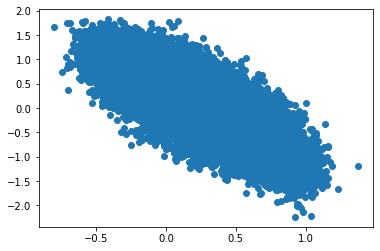

In [35]:
x = df_sub['all_privat']
y = df_sub['all_public']

plt.scatter(x, y)
plt.show()

In [4]:
for i in df_sub.columns:

    X = df_sub.loc[:,[i, 'female_dummy']] # raw is ref
    y = df_sub.loc[:, 'religiousGarmentFemale_dummy']

    m = PanelOLS(dependent=y,
                exog=X,
                entity_effects=True,
                time_effects=True,
                drop_absorbed = True)

    # m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

    try:
        output = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)
        print(output)

    except:
        pass

                               PanelOLS Estimation Summary                                
Dep. Variable:     religiousGarmentFemale_dummy   R-squared:                        0.0929
Estimator:                             PanelOLS   R-squared (Between):              0.4881
No. Observations:                        126548   R-squared (Within):               0.1007
Date:                          Tue, Oct 25 2022   R-squared (Overall):              0.1509
Time:                                  10:46:27   Log-likelihood                 1.015e+04
Cov. Estimator:                       Clustered                                           
                                                  F-statistic:                      6476.0
Entities:                                    23   P-value                           0.0000
Avg Obs:                                 5502.1   Distribution:                F(2,126476)
Min Obs:                                 2.0000                                           

/home/simon/anaconda3/envs/scikit_env/lib/python3.8/site-packages/linearmodels/panel/results.py:87: RuntimeWarning: invalid value encountered in sqrt
  return Series(np.sqrt(np.diag(self.cov)), self._var_names, name="std_error")
/home/simon/anaconda3/envs/scikit_env/lib/python3.8/site-packages/linearmodels/panel/results.py:87: RuntimeWarning: invalid value encountered in sqrt
  return Series(np.sqrt(np.diag(self.cov)), self._var_names, name="std_error")
/home/simon/anaconda3/envs/scikit_env/lib/python3.8/site-packages/linearmodels/panel/results.py:87: RuntimeWarning: invalid value encountered in sqrt
  return Series(np.sqrt(np.diag(self.cov)), self._var_names, name="std_error")
/home/simon/anaconda3/envs/scikit_env/lib/python3.8/site-packages/linearmodels/panel/results.py:87: RuntimeWarning: invalid value encountered in sqrt
  return Series(np.sqrt(np.diag(self.cov)), self._var_names, name="std_error")


                               PanelOLS Estimation Summary                                
Dep. Variable:     religiousGarmentFemale_dummy   R-squared:                        0.6335
Estimator:                             PanelOLS   R-squared (Between):              0.9516
No. Observations:                        126548   R-squared (Within):               0.6379
Date:                          Tue, Oct 25 2022   R-squared (Overall):              0.6610
Time:                                  10:46:40   Log-likelihood                  6.75e+04
Cov. Estimator:                       Clustered                                           
                                                  F-statistic:                   1.093e+05
Entities:                                    23   P-value                           0.0000
Avg Obs:                                 5502.1   Distribution:                F(2,126476)
Min Obs:                                 2.0000                                           

/home/simon/anaconda3/envs/scikit_env/lib/python3.8/site-packages/linearmodels/panel/results.py:87: RuntimeWarning: invalid value encountered in sqrt
  return Series(np.sqrt(np.diag(self.cov)), self._var_names, name="std_error")
/home/simon/anaconda3/envs/scikit_env/lib/python3.8/site-packages/linearmodels/panel/results.py:87: RuntimeWarning: invalid value encountered in sqrt
  return Series(np.sqrt(np.diag(self.cov)), self._var_names, name="std_error")
/home/simon/anaconda3/envs/scikit_env/lib/python3.8/site-packages/linearmodels/panel/results.py:87: RuntimeWarning: invalid value encountered in sqrt
  return Series(np.sqrt(np.diag(self.cov)), self._var_names, name="std_error")
/home/simon/anaconda3/envs/scikit_env/lib/python3.8/site-packages/linearmodels/panel/results.py:87: RuntimeWarning: invalid value encountered in sqrt
  return Series(np.sqrt(np.diag(self.cov)), self._var_names, name="std_error")


                               PanelOLS Estimation Summary                                
Dep. Variable:     religiousGarmentFemale_dummy   R-squared:                        0.0810
Estimator:                             PanelOLS   R-squared (Between):              0.4532
No. Observations:                        126548   R-squared (Within):               0.0881
Date:                          Tue, Oct 25 2022   R-squared (Overall):              0.1471
Time:                                  10:46:49   Log-likelihood                    9325.4
Cov. Estimator:                       Clustered                                           
                                                  F-statistic:                      5571.1
Entities:                                    23   P-value                           0.0000
Avg Obs:                                 5502.1   Distribution:                F(2,126476)
Min Obs:                                 2.0000                                           

/tmp/ipykernel_89059/1234678635.py:15: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

nlights_calib_mean_observed

  output = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)


                               PanelOLS Estimation Summary                                
Dep. Variable:     religiousGarmentFemale_dummy   R-squared:                        0.0810
Estimator:                             PanelOLS   R-squared (Between):              0.4531
No. Observations:                        126548   R-squared (Within):               0.0881
Date:                          Tue, Oct 25 2022   R-squared (Overall):              0.1471
Time:                                  10:47:01   Log-likelihood                    9325.4
Cov. Estimator:                       Clustered                                           
                                                  F-statistic:                   1.114e+04
Entities:                                    23   P-value                           0.0000
Avg Obs:                                 5502.1   Distribution:                F(1,126477)
Min Obs:                                 2.0000                                           

/tmp/ipykernel_89059/1234678635.py:15: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

nlights_mean_observed

  output = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)


                               PanelOLS Estimation Summary                                
Dep. Variable:     religiousGarmentFemale_dummy   R-squared:                        0.0810
Estimator:                             PanelOLS   R-squared (Between):              0.4531
No. Observations:                        126548   R-squared (Within):               0.0881
Date:                          Tue, Oct 25 2022   R-squared (Overall):              0.1471
Time:                                  10:47:03   Log-likelihood                    9325.4
Cov. Estimator:                       Clustered                                           
                                                  F-statistic:                   1.114e+04
Entities:                                    23   P-value                           0.0000
Avg Obs:                                 5502.1   Distribution:                F(1,126477)
Min Obs:                                 2.0000                                           

/tmp/ipykernel_89059/1234678635.py:15: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

cmr_mean

  output = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)


                               PanelOLS Estimation Summary                                
Dep. Variable:     religiousGarmentFemale_dummy   R-squared:                        0.0810
Estimator:                             PanelOLS   R-squared (Between):              0.4531
No. Observations:                        126548   R-squared (Within):               0.0881
Date:                          Tue, Oct 25 2022   R-squared (Overall):              0.1471
Time:                                  10:47:05   Log-likelihood                    9325.4
Cov. Estimator:                       Clustered                                           
                                                  F-statistic:                   1.114e+04
Entities:                                    23   P-value                           0.0000
Avg Obs:                                 5502.1   Distribution:                F(1,126477)
Min Obs:                                 2.0000                                           

/tmp/ipykernel_89059/1234678635.py:15: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

imr_mean

  output = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)


                               PanelOLS Estimation Summary                                
Dep. Variable:     religiousGarmentFemale_dummy   R-squared:                        0.0810
Estimator:                             PanelOLS   R-squared (Between):              0.4531
No. Observations:                        126548   R-squared (Within):               0.0881
Date:                          Tue, Oct 25 2022   R-squared (Overall):              0.1471
Time:                                  10:47:07   Log-likelihood                    9325.4
Cov. Estimator:                       Clustered                                           
                                                  F-statistic:                   1.114e+04
Entities:                                    23   P-value                           0.0000
Avg Obs:                                 5502.1   Distribution:                F(1,126477)
Min Obs:                                 2.0000                                           

/tmp/ipykernel_89059/1234678635.py:15: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

mountains_mean

  output = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)


                               PanelOLS Estimation Summary                                
Dep. Variable:     religiousGarmentFemale_dummy   R-squared:                        0.0810
Estimator:                             PanelOLS   R-squared (Between):              0.4531
No. Observations:                        126548   R-squared (Within):               0.0881
Date:                          Tue, Oct 25 2022   R-squared (Overall):              0.1471
Time:                                  10:47:09   Log-likelihood                    9325.4
Cov. Estimator:                       Clustered                                           
                                                  F-statistic:                   1.114e+04
Entities:                                    23   P-value                           0.0000
Avg Obs:                                 5502.1   Distribution:                F(1,126477)
Min Obs:                                 2.0000                                           

/tmp/ipykernel_89059/1234678635.py:15: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

ttime_mean

  output = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)


                               PanelOLS Estimation Summary                                
Dep. Variable:     religiousGarmentFemale_dummy   R-squared:                        0.0810
Estimator:                             PanelOLS   R-squared (Between):              0.4531
No. Observations:                        126548   R-squared (Within):               0.0881
Date:                          Tue, Oct 25 2022   R-squared (Overall):              0.1471
Time:                                  10:47:11   Log-likelihood                    9325.4
Cov. Estimator:                       Clustered                                           
                                                  F-statistic:                   1.114e+04
Entities:                                    23   P-value                           0.0000
Avg Obs:                                 5502.1   Distribution:                F(1,126477)
Min Obs:                                 2.0000                                           

AttributeError: 'DataFrame' object has no attribute 'dtype'

In [52]:
X = df_sub.loc[:,['person_mean', 'female_mean', 'religiousGarmentFemale_mean']] # raw is ref
y = df_sub.loc[:, 'Submitted']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

output = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)
print(output)


                          PanelOLS Estimation Summary                           
Dep. Variable:              Submitted   R-squared:                        0.0002
Estimator:                   PanelOLS   R-squared (Between):             -0.0009
No. Observations:              126548   R-squared (Within):           -6.186e-05
Date:                Tue, Oct 25 2022   R-squared (Overall):              0.0003
Time:                        10:10:13   Log-likelihood                 4.117e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      8.4596
Entities:                          23   P-value                           0.0000
Avg Obs:                       5502.1   Distribution:                F(3,126475)
Min Obs:                       2.0000                                           
Max Obs:                    1.035e+05   F-statistic (robust):            -2.4260
                            

In [49]:
#df_sub.loc[[df_sub['Published'] == 0],['person_mean', 'female_mean']] 

df_sub[df_sub['Published'] == 0].loc[:,['person_mean', 'female_mean']] 


person_mean  female_mean
gid    month_id                          
177569 348               3.0          0.0
       357               3.0          0.0
       334               1.6          0.0
179003 311               2.8          0.0
       311               1.8          0.5
...                      ...          ...
179009 289               2.8          0.5
       289               0.6          0.0
       289               2.0          1.0
       289               4.8          0.5
       289               6.8          0.5

[126093 rows x 2 columns]

In [51]:
X = df_sub.loc[df_sub['Published'] == 0,['person_mean', 'female_mean']] # raw is ref
y = df_sub.loc[df_sub['Published'] == 0, 'Submitted']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

output = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)
print(output)

                          PanelOLS Estimation Summary                           
Dep. Variable:              Submitted   R-squared:                        0.0002
Estimator:                   PanelOLS   R-squared (Between):             -0.0008
No. Observations:              126093   R-squared (Within):           -4.356e-05
Date:                Mon, Oct 24 2022   R-squared (Overall):              0.0003
Time:                        23:55:43   Log-likelihood                  4.08e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      12.402
Entities:                          23   P-value                           0.0000
Avg Obs:                       5482.3   Distribution:                F(2,126022)
Min Obs:                       2.0000                                           
Max Obs:                     1.03e+05   F-statistic (robust):             3.0811
                            

In [60]:
X = df_sub.loc[df_sub['Published'] == 0,['person_mean', 'female_mean']] # raw is ref
y = df_sub.loc[df_sub['Published'] == 0, 'Submitted']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

output = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)
print(output)

                          PanelOLS Estimation Summary                           
Dep. Variable:              Submitted   R-squared:                        0.0002
Estimator:                   PanelOLS   R-squared (Between):             -0.0008
No. Observations:              126093   R-squared (Within):           -4.356e-05
Date:                Tue, Oct 25 2022   R-squared (Overall):              0.0003
Time:                        00:00:40   Log-likelihood                  4.08e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      12.402
Entities:                          23   P-value                           0.0000
Avg Obs:                       5482.3   Distribution:                F(2,126022)
Min Obs:                       2.0000                                           
Max Obs:                     1.03e+05   F-statistic (robust):             3.0811
                            

In [82]:
X = df_sub.loc[df_sub['Published'] == 0,['person_dummy', 'female_dummy']] # raw is ref
y = df_sub.loc[df_sub['Published'] == 0, 'Submitted']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

output = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)
print(output)

                          PanelOLS Estimation Summary                           
Dep. Variable:              Submitted   R-squared:                        0.0001
Estimator:                   PanelOLS   R-squared (Between):              0.0116
No. Observations:              126093   R-squared (Within):            5.164e-05
Date:                Tue, Oct 25 2022   R-squared (Overall):              0.0099
Time:                        00:17:24   Log-likelihood                 4.079e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      7.1483
Entities:                          23   P-value                           0.0008
Avg Obs:                       5482.3   Distribution:                F(2,126022)
Min Obs:                       2.0000                                           
Max Obs:                     1.03e+05   F-statistic (robust):             9.0600
                            

In [59]:
X = df_sub.loc[df_sub['Published'] == 0,['female_mean', 'religiousGarmentFemale_mean']] # raw is ref
y = df_sub.loc[df_sub['Published'] == 0, 'Submitted']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

output = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)
print(output)

                          PanelOLS Estimation Summary                           
Dep. Variable:              Submitted   R-squared:                        0.0001
Estimator:                   PanelOLS   R-squared (Between):              0.0026
No. Observations:              126093   R-squared (Within):           -4.754e-05
Date:                Mon, Oct 24 2022   R-squared (Overall):              0.0030
Time:                        23:59:35   Log-likelihood                 4.079e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      8.9682
Entities:                          23   P-value                           0.0001
Avg Obs:                       5482.3   Distribution:                F(2,126022)
Min Obs:                       2.0000                                           
Max Obs:                     1.03e+05   F-statistic (robust):            -18.153
                            

In [87]:
X = df_sub.loc[df_sub['Published'] == 0,['female_dummy', 'religiousGarmentFemale_mean']] # raw is ref
y = df_sub.loc[df_sub['Published'] == 0, 'Submitted']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

output = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)
print(output)

                          PanelOLS Estimation Summary                           
Dep. Variable:              Submitted   R-squared:                     8.742e-05
Estimator:                   PanelOLS   R-squared (Between):              0.0021
No. Observations:              126093   R-squared (Within):           -4.761e-05
Date:                Tue, Oct 25 2022   R-squared (Overall):              0.0022
Time:                        00:30:14   Log-likelihood                 4.079e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      5.5091
Entities:                          23   P-value                           0.0041
Avg Obs:                       5482.3   Distribution:                F(2,126022)
Min Obs:                       2.0000                                           
Max Obs:                     1.03e+05   F-statistic (robust):            -92.823
                            

In [91]:
X = df_sub.loc[df_sub['Published'] == 0,['religiousGarmentFemale_mean']] # raw is ref
y = df_sub.loc[df_sub['Published'] == 0, 'Submitted']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

output = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)
print(output)

                          PanelOLS Estimation Summary                           
Dep. Variable:              Submitted   R-squared:                     8.053e-05
Estimator:                   PanelOLS   R-squared (Between):              0.0011
No. Observations:              126093   R-squared (Within):            -2.82e-05
Date:                Tue, Oct 25 2022   R-squared (Overall):              0.0012
Time:                        00:34:38   Log-likelihood                 4.079e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      10.149
Entities:                          23   P-value                           0.0014
Avg Obs:                       5482.3   Distribution:                F(1,126023)
Min Obs:                       2.0000                                           
Max Obs:                     1.03e+05   F-statistic (robust):             130.89
                            

In [98]:
X = df_sub.loc[df_sub['Published'] == 0,['all_militarized','female_mean']] # raw is ref
y = df_sub.loc[df_sub['Published'] == 0, 'Submitted']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

output = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)
print(output)

                          PanelOLS Estimation Summary                           
Dep. Variable:              Submitted   R-squared:                        0.0002
Estimator:                   PanelOLS   R-squared (Between):              0.0010
No. Observations:              126093   R-squared (Within):              -0.0002
Date:                Tue, Oct 25 2022   R-squared (Overall):              0.0017
Time:                        00:39:46   Log-likelihood                 4.079e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      11.306
Entities:                          23   P-value                           0.0000
Avg Obs:                       5482.3   Distribution:                F(2,126022)
Min Obs:                       2.0000                                           
Max Obs:                     1.03e+05   F-statistic (robust):             8.9692
                            

In [100]:
X = df_sub.loc[df_sub['Published'] == 0,['intMilFem', 'all_militarized','female_mean']] # raw is ref
y = df_sub.loc[df_sub['Published'] == 0, 'Submitted']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

output = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)
print(output)

                          PanelOLS Estimation Summary                           
Dep. Variable:              Submitted   R-squared:                        0.0003
Estimator:                   PanelOLS   R-squared (Between):              0.0015
No. Observations:              126093   R-squared (Within):           -8.913e-05
Date:                Tue, Oct 25 2022   R-squared (Overall):              0.0018
Time:                        00:42:29   Log-likelihood                  4.08e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      11.497
Entities:                          23   P-value                           0.0000
Avg Obs:                       5482.3   Distribution:                F(3,126021)
Min Obs:                       2.0000                                           
Max Obs:                     1.03e+05   F-statistic (robust):             19.865
                            

In [107]:
X = df_sub.loc[df_sub['Published'] == 0,['intMilGar', 'all_militarized','religiousGarmentFemale_mean']] # raw is ref
y = df_sub.loc[df_sub['Published'] == 0, 'Submitted']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

output = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)
print(output)

                          PanelOLS Estimation Summary                           
Dep. Variable:              Submitted   R-squared:                        0.0002
Estimator:                   PanelOLS   R-squared (Between):             -0.0003
No. Observations:              126093   R-squared (Within):              -0.0002
Date:                Tue, Oct 25 2022   R-squared (Overall):              0.0001
Time:                        00:47:01   Log-likelihood                  4.08e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      7.8284
Entities:                          23   P-value                           0.0000
Avg Obs:                       5482.3   Distribution:                F(3,126021)
Min Obs:                       2.0000                                           
Max Obs:                     1.03e+05   F-statistic (robust):            -31.834
                            

In [102]:
X = df_sub.loc[df_sub['Published'] == 0,['intUnGar', 'all_militarized','religiousGarmentFemale_mean']] # raw is ref
y = df_sub.loc[df_sub['Published'] == 0, 'Submitted']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

output = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)
print(output)

                          PanelOLS Estimation Summary                           
Dep. Variable:              Submitted   R-squared:                        0.0002
Estimator:                   PanelOLS   R-squared (Between):             -0.0004
No. Observations:              126093   R-squared (Within):              -0.0002
Date:                Tue, Oct 25 2022   R-squared (Overall):           7.656e-05
Time:                        00:44:18   Log-likelihood                 4.079e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      6.7819
Entities:                          23   P-value                           0.0001
Avg Obs:                       5482.3   Distribution:                F(3,126021)
Min Obs:                       2.0000                                           
Max Obs:                     1.03e+05   F-statistic (robust):            -32.210
                            

In [104]:
X = df_sub.loc[df_sub['Published'] == 0,['intUnFem', 'all_militarized','female_mean']] # raw is ref
y = df_sub.loc[df_sub['Published'] == 0, 'Submitted']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

output = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)
print(output)

                          PanelOLS Estimation Summary                           
Dep. Variable:              Submitted   R-squared:                        0.0002
Estimator:                   PanelOLS   R-squared (Between):              0.0013
No. Observations:              126093   R-squared (Within):              -0.0002
Date:                Tue, Oct 25 2022   R-squared (Overall):              0.0017
Time:                        00:45:09   Log-likelihood                  4.08e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      8.7991
Entities:                          23   P-value                           0.0000
Avg Obs:                       5482.3   Distribution:                F(3,126021)
Min Obs:                       2.0000                                           
Max Obs:                     1.03e+05   F-statistic (robust):             6.1323
                            

In [111]:
X = df_sub.loc[df_sub['Published'] == 0,[ 'all_militarized', 'person_dummy']] # raw is ref
y = df_sub.loc[df_sub['Published'] == 0, 'female_dummy']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

output = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)
print(output)

                          PanelOLS Estimation Summary                           
Dep. Variable:           female_dummy   R-squared:                        0.2597
Estimator:                   PanelOLS   R-squared (Between):              0.7675
No. Observations:              126093   R-squared (Within):               0.2878
Date:                Tue, Oct 25 2022   R-squared (Overall):              0.6060
Time:                        00:50:43   Log-likelihood                -6.617e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                    2.21e+04
Entities:                          23   P-value                           0.0000
Avg Obs:                       5482.3   Distribution:                F(2,126022)
Min Obs:                       2.0000                                           
Max Obs:                     1.03e+05   F-statistic (robust):             2495.6
                            

In [112]:
X = df_sub.loc[df_sub['Published'] == 0,[ 'all_militarized', 'person_mean']] # raw is ref
y = df_sub.loc[df_sub['Published'] == 0, 'female_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

output = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)
print(output)

                          PanelOLS Estimation Summary                           
Dep. Variable:            female_mean   R-squared:                        0.3707
Estimator:                   PanelOLS   R-squared (Between):              0.7183
No. Observations:              126093   R-squared (Within):               0.3947
Date:                Tue, Oct 25 2022   R-squared (Overall):              0.5903
Time:                        00:51:10   Log-likelihood                -1.339e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                   3.711e+04
Entities:                          23   P-value                           0.0000
Avg Obs:                       5482.3   Distribution:                F(2,126022)
Min Obs:                       2.0000                                           
Max Obs:                     1.03e+05   F-statistic (robust):             1744.9
                            

In [113]:
X = df_sub.loc[df_sub['Published'] == 0,[ 'all_militarized', 'person_dummy']] # raw is ref
y = df_sub.loc[df_sub['Published'] == 0, 'religiousGarmentFemale_dummy']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

output = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)
print(output)

                               PanelOLS Estimation Summary                                
Dep. Variable:     religiousGarmentFemale_dummy   R-squared:                        0.0695
Estimator:                             PanelOLS   R-squared (Between):              0.6431
No. Observations:                        126093   R-squared (Within):               0.0833
Date:                          Tue, Oct 25 2022   R-squared (Overall):              0.2377
Time:                                  00:52:12   Log-likelihood                -5.434e+04
Cov. Estimator:                       Clustered                                           
                                                  F-statistic:                      4706.7
Entities:                                    23   P-value                           0.0000
Avg Obs:                                 5482.3   Distribution:                F(2,126022)
Min Obs:                                 2.0000                                           

In [115]:
X = df_sub.loc[df_sub['Published'] == 0,[ 'all_militarized', 'person_mean']] # raw is ref
y = df_sub.loc[df_sub['Published'] == 0, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

output = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)
print(output)

                               PanelOLS Estimation Summary                               
Dep. Variable:     religiousGarmentFemale_mean   R-squared:                        0.1013
Estimator:                            PanelOLS   R-squared (Between):              0.5245
No. Observations:                       126093   R-squared (Within):               0.1150
Date:                         Tue, Oct 25 2022   R-squared (Overall):              0.2303
Time:                                 00:52:42   Log-likelihood                  -3.6e+04
Cov. Estimator:                      Clustered                                           
                                                 F-statistic:                      7099.1
Entities:                                   23   P-value                           0.0000
Avg Obs:                                5482.3   Distribution:                F(2,126022)
Min Obs:                                2.0000                                           
Max Obs:  

In [116]:
X = df_sub.loc[df_sub['Published'] == 0,[ 'all_militarized', 'female_dummy']] # raw is ref
y = df_sub.loc[df_sub['Published'] == 0, 'religiousGarmentFemale_dummy']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

output = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)
print(output)

                               PanelOLS Estimation Summary                                
Dep. Variable:     religiousGarmentFemale_dummy   R-squared:                        0.1452
Estimator:                             PanelOLS   R-squared (Between):              0.8070
No. Observations:                        126093   R-squared (Within):               0.1604
Date:                          Tue, Oct 25 2022   R-squared (Overall):              0.3178
Time:                                  00:52:58   Log-likelihood                -4.899e+04
Cov. Estimator:                       Clustered                                           
                                                  F-statistic:                   1.071e+04
Entities:                                    23   P-value                           0.0000
Avg Obs:                                 5482.3   Distribution:                F(2,126022)
Min Obs:                                 2.0000                                           

In [117]:
X = df_sub.loc[df_sub['Published'] == 0,[ 'all_militarized', 'female_mean']] # raw is ref
y = df_sub.loc[df_sub['Published'] == 0, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

output = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)
print(output)

                               PanelOLS Estimation Summary                               
Dep. Variable:     religiousGarmentFemale_mean   R-squared:                        0.3378
Estimator:                            PanelOLS   R-squared (Between):              0.9159
No. Observations:                       126093   R-squared (Within):               0.3497
Date:                         Tue, Oct 25 2022   R-squared (Overall):              0.4445
Time:                                 00:53:20   Log-likelihood                -1.675e+04
Cov. Estimator:                      Clustered                                           
                                                 F-statistic:                   3.214e+04
Entities:                                   23   P-value                           0.0000
Avg Obs:                                5482.3   Distribution:                F(2,126022)
Min Obs:                                2.0000                                           
Max Obs:  

In [ ]:

df_sub['intMilFem']
df_sub['intMilGar'] 
df_sub['intUnFem'] 
df_sub['intUnGar']

In [33]:
X = df_sub.loc[:,['person_mean', 'female_mean']] # raw is ref
y = df_sub.loc[:, 'Submitted']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

output = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)
print(output)

                          PanelOLS Estimation Summary                           
Dep. Variable:              Submitted   R-squared:                        0.0002
Estimator:                   PanelOLS   R-squared (Between):             -0.0009
No. Observations:              126548   R-squared (Within):           -5.731e-05
Date:                Mon, Oct 24 2022   R-squared (Overall):              0.0003
Time:                        23:49:00   Log-likelihood                 4.117e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      12.367
Entities:                          23   P-value                           0.0000
Avg Obs:                       5502.1   Distribution:                F(2,126476)
Min Obs:                       2.0000                                           
Max Obs:                    1.035e+05   F-statistic (robust):             3.0983
                            

In [13]:
X = df_sub.loc[:,['uniformed_mean', 'person_mean']] # raw is ref
y = df_sub.loc[:, 'female_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

Dep. Variable:,female_mean,R-squared:,0.3401
Estimator:,PanelOLS,R-squared (Between):,0.7340
No. Observations:,126548,R-squared (Within):,0.3606
Date:,"Mon, Oct 24 2022",R-squared (Overall):,0.5706
Time:,23:26:29,Log-likelihood,-1.376e+05
Cov. Estimator:,Clustered,,
,,F-statistic:,3.259e+04
Entities:,23,P-value,0.0000
Avg Obs:,5502.1,Distribution:,"F(2,126476)"
Min Obs:,2.0000,,
Max Obs:,1.035e+05,F-statistic (robust):,5824.4


In [12]:
X = df_sub.loc[:,['uniformed_mean','female_mean']] # raw is ref
y = df_sub.loc[:, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

Dep. Variable:,religiousGarmentFemale_mean,R-squared:,0.3406
Estimator:,PanelOLS,R-squared (Between):,0.9168
No. Observations:,126548,R-squared (Within):,0.3528
Date:,"Fri, Oct 07 2022",R-squared (Overall):,0.4454
Time:,03:11:49,Log-likelihood,-1.738e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,3.267e+04
Entities:,23,P-value,0.0000
Avg Obs:,5502.1,Distribution:,"F(2,126476)"
Min Obs:,2.0000,,
Max Obs:,1.035e+05,F-statistic (robust):,1685.6


In [13]:
X = df_sub.loc[:,['all_militarized', 'person_mean']] # raw is ref
y = df_sub.loc[:, 'female_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

Dep. Variable:,female_mean,R-squared:,0.3708
Estimator:,PanelOLS,R-squared (Between):,0.7200
No. Observations:,126548,R-squared (Within):,0.3950
Date:,"Fri, Oct 07 2022",R-squared (Overall):,0.5912
Time:,03:11:56,Log-likelihood,-1.346e+05
Cov. Estimator:,Clustered,,
,,F-statistic:,3.727e+04
Entities:,23,P-value,0.0000
Avg Obs:,5502.1,Distribution:,"F(2,126476)"
Min Obs:,2.0000,,
Max Obs:,1.035e+05,F-statistic (robust):,1823.9


In [14]:
X = df_sub.loc[:,['all_militarized','female_mean']] # raw is ref
y = df_sub.loc[:, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

Dep. Variable:,religiousGarmentFemale_mean,R-squared:,0.3402
Estimator:,PanelOLS,R-squared (Between):,0.9178
No. Observations:,126548,R-squared (Within):,0.3525
Date:,"Fri, Oct 07 2022",R-squared (Overall):,0.4465
Time:,03:12:23,Log-likelihood,-1.742e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,3.26e+04
Entities:,23,P-value,0.0000
Avg Obs:,5502.1,Distribution:,"F(2,126476)"
Min Obs:,2.0000,,
Max Obs:,1.035e+05,F-statistic (robust):,1660.1


In [5]:
X = df_sub.loc[:,['log_best']] # raw is ref
y = df_sub.loc[:, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

Dep. Variable:,religiousGarmentFemale_mean,R-squared:,6.96e-06
Estimator:,PanelOLS,R-squared (Between):,-0.0097
No. Observations:,126548,R-squared (Within):,-0.0008
Date:,"Fri, Oct 07 2022",R-squared (Overall):,-0.0242
Time:,03:08:31,Log-likelihood,-4.373e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,0.8803
Entities:,23,P-value,0.3481
Avg Obs:,5502.1,Distribution:,"F(1,126477)"
Min Obs:,2.0000,,
Max Obs:,1.035e+05,F-statistic (robust):,0.3742


In [24]:
X = df_sub.loc[:,['tce']] # raw is ref
y = df_sub.loc[:, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

Dep. Variable:,religiousGarmentFemale_mean,R-squared:,0.0004
Estimator:,PanelOLS,R-squared (Between):,0.0599
No. Observations:,126548,R-squared (Within):,0.0007
Date:,"Tue, Oct 04 2022",R-squared (Overall):,0.1194
Time:,21:05:15,Log-likelihood,-4.371e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,51.604
Entities:,23,P-value,0.0000
Avg Obs:,5502.1,Distribution:,"F(1,126477)"
Min Obs:,2.0000,,
Max Obs:,1.035e+05,F-statistic (robust):,1.1454


In [25]:
X = df_sub.loc[:,['tsce']] # raw is ref
y = df_sub.loc[:, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

Dep. Variable:,religiousGarmentFemale_mean,R-squared:,0.0003
Estimator:,PanelOLS,R-squared (Between):,0.0878
No. Observations:,126548,R-squared (Within):,-0.0012
Date:,"Tue, Oct 04 2022",R-squared (Overall):,0.1217
Time:,21:05:25,Log-likelihood,-4.371e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,37.194
Entities:,23,P-value,0.0000
Avg Obs:,5502.1,Distribution:,"F(1,126477)"
Min Obs:,2.0000,,
Max Obs:,1.035e+05,F-statistic (robust):,1.2294


In [27]:
X = df_sub.loc[:,['tsce', 'female_mean']] # raw is ref
y = df_sub.loc[:, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

Dep. Variable:,religiousGarmentFemale_mean,R-squared:,0.3401
Estimator:,PanelOLS,R-squared (Between):,0.8834
No. Observations:,126548,R-squared (Within):,0.3479
Date:,"Tue, Oct 04 2022",R-squared (Overall):,0.3596
Time:,21:06:27,Log-likelihood,-1.743e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,3.259e+04
Entities:,23,P-value,0.0000
Avg Obs:,5502.1,Distribution:,"F(2,126476)"
Min Obs:,2.0000,,
Max Obs:,1.035e+05,F-statistic (robust):,1661.6


In [28]:
X = df_sub.loc[:,['tce', 'female_mean']] # raw is ref
y = df_sub.loc[:, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

Dep. Variable:,religiousGarmentFemale_mean,R-squared:,0.3402
Estimator:,PanelOLS,R-squared (Between):,0.8947
No. Observations:,126548,R-squared (Within):,0.3494
Date:,"Tue, Oct 04 2022",R-squared (Overall):,0.3711
Time:,21:06:58,Log-likelihood,-1.742e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,3.26e+04
Entities:,23,P-value,0.0000
Avg Obs:,5502.1,Distribution:,"F(2,126476)"
Min Obs:,2.0000,,
Max Obs:,1.035e+05,F-statistic (robust):,1782.0


In [29]:
X = df_sub.loc[:,['log_best', 'female_mean']] # raw is ref
y = df_sub.loc[:, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

Dep. Variable:,religiousGarmentFemale_mean,R-squared:,0.3399
Estimator:,PanelOLS,R-squared (Between):,0.9112
No. Observations:,126548,R-squared (Within):,0.3509
Date:,"Tue, Oct 04 2022",R-squared (Overall):,0.4271
Time:,21:07:06,Log-likelihood,-1.745e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,3.257e+04
Entities:,23,P-value,0.0000
Avg Obs:,5502.1,Distribution:,"F(2,126476)"
Min Obs:,2.0000,,
Max Obs:,1.035e+05,F-statistic (robust):,1399.0


In [30]:
X = df_sub.loc[:,['log_best', 'female_mean', 'person_mean']] # raw is ref
y = df_sub.loc[:, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

Dep. Variable:,religiousGarmentFemale_mean,R-squared:,0.3416
Estimator:,PanelOLS,R-squared (Between):,0.9101
No. Observations:,126548,R-squared (Within):,0.3525
Date:,"Tue, Oct 04 2022",R-squared (Overall):,0.4384
Time:,21:07:56,Log-likelihood,-1.729e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,2.187e+04
Entities:,23,P-value,0.0000
Avg Obs:,5502.1,Distribution:,"F(3,126475)"
Min Obs:,2.0000,,
Max Obs:,1.035e+05,F-statistic (robust):,-884.54


In [31]:
X = df_sub.loc[:,['tce', 'female_mean', 'person_mean']] # raw is ref
y = df_sub.loc[:, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

Dep. Variable:,religiousGarmentFemale_mean,R-squared:,0.3418
Estimator:,PanelOLS,R-squared (Between):,0.9012
No. Observations:,126548,R-squared (Within):,0.3512
Date:,"Tue, Oct 04 2022",R-squared (Overall):,0.4000
Time:,21:08:47,Log-likelihood,-1.727e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,2.189e+04
Entities:,23,P-value,0.0000
Avg Obs:,5502.1,Distribution:,"F(3,126475)"
Min Obs:,2.0000,,
Max Obs:,1.035e+05,F-statistic (robust):,-749.24


In [34]:
X = df_sub.loc[:,['tsce', 'female_mean', 'person_mean']] # raw is ref
y = df_sub.loc[:, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

Dep. Variable:,religiousGarmentFemale_mean,R-squared:,0.3417
Estimator:,PanelOLS,R-squared (Between):,0.8943
No. Observations:,126548,R-squared (Within):,0.3500
Date:,"Tue, Oct 04 2022",R-squared (Overall):,0.3926
Time:,21:11:36,Log-likelihood,-1.727e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,2.189e+04
Entities:,23,P-value,0.0000
Avg Obs:,5502.1,Distribution:,"F(3,126475)"
Min Obs:,2.0000,,
Max Obs:,1.035e+05,F-statistic (robust):,-249.75


In [ ]:
X = df_sub.loc[:,['female_mean', 'person_mean']] # raw is ref
y = df_sub.loc[:, 'log_best']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

In [9]:
X = df_sub.loc[:,['female_mean', 'person_mean']] # raw is ref
y = df_sub.loc[:, 'log_best']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

Dep. Variable:,log_best,R-squared:,0.0003
Estimator:,PanelOLS,R-squared (Between):,-0.0023
No. Observations:,126548,R-squared (Within):,-0.0003
Date:,"Tue, Oct 04 2022",R-squared (Overall):,-0.0025
Time:,17:26:14,Log-likelihood,-3667.6
Cov. Estimator:,Clustered,,
,,F-statistic:,21.630
Entities:,23,P-value,0.0000
Avg Obs:,5502.1,Distribution:,"F(2,126476)"
Min Obs:,2.0000,,
Max Obs:,1.035e+05,F-statistic (robust):,0.4457


In [10]:
X = df_sub.loc[:,['female_mean', 'person_mean']] # raw is ref
y = df_sub.loc[:, 'tce']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

Dep. Variable:,tce,R-squared:,0.0014
Estimator:,PanelOLS,R-squared (Between):,-0.0071
No. Observations:,126548,R-squared (Within):,0.0008
Date:,"Tue, Oct 04 2022",R-squared (Overall):,-0.0044
Time:,17:26:16,Log-likelihood,4602.8
Cov. Estimator:,Clustered,,
,,F-statistic:,87.978
Entities:,23,P-value,0.0000
Avg Obs:,5502.1,Distribution:,"F(2,126476)"
Min Obs:,2.0000,,
Max Obs:,1.035e+05,F-statistic (robust):,0.8391


In [11]:
X = df_sub.loc[:,['female_mean', 'person_mean']] # raw is ref
y = df_sub.loc[:, 'tsce']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

Dep. Variable:,tsce,R-squared:,0.0013
Estimator:,PanelOLS,R-squared (Between):,-0.0067
No. Observations:,126548,R-squared (Within):,0.0005
Date:,"Tue, Oct 04 2022",R-squared (Overall):,-0.0037
Time:,17:26:18,Log-likelihood,1.117e+05
Cov. Estimator:,Clustered,,
,,F-statistic:,83.601
Entities:,23,P-value,0.0000
Avg Obs:,5502.1,Distribution:,"F(2,126476)"
Min Obs:,2.0000,,
Max Obs:,1.035e+05,F-statistic (robust):,0.9545


In [86]:
X = df_sub.loc[:,['falgIRQ_mean', 'flagUS_mean', 'uniformed_mean', 'militaryVehicle_mean']] # raw is ref
y = df_sub.loc[:, 'female_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

Dep. Variable:,female_mean,R-squared:,0.0526
Estimator:,PanelOLS,R-squared (Between):,-0.1516
No. Observations:,126548,R-squared (Within):,0.0707
Date:,"Tue, Oct 04 2022",R-squared (Overall):,-0.0666
Time:,22:24:31,Log-likelihood,-1.605e+05
Cov. Estimator:,Clustered,,
,,F-statistic:,1755.4
Entities:,23,P-value,0.0000
Avg Obs:,5502.1,Distribution:,"F(4,126474)"
Min Obs:,2.0000,,
Max Obs:,1.035e+05,F-statistic (robust):,16.827


In [87]:
X = df_sub.loc[:,['falgIRQ_mean', 'flagUS_mean', 'uniformed_mean', 'militaryVehicle_mean', 'female_mean']] # raw is ref
y = df_sub.loc[:, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

Dep. Variable:,religiousGarmentFemale_mean,R-squared:,0.3430
Estimator:,PanelOLS,R-squared (Between):,0.9149
No. Observations:,126548,R-squared (Within):,0.3555
Date:,"Tue, Oct 04 2022",R-squared (Overall):,0.4460
Time:,22:25:18,Log-likelihood,-1.715e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,1.321e+04
Entities:,23,P-value,0.0000
Avg Obs:,5502.1,Distribution:,"F(5,126473)"
Min Obs:,2.0000,,
Max Obs:,1.035e+05,F-statistic (robust):,1109.6


In [90]:
X = df_sub.loc[:,['uniformed_mean', 'person_mean']] # raw is ref
y = df_sub.loc[:, 'female_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

Dep. Variable:,female_mean,R-squared:,0.3401
Estimator:,PanelOLS,R-squared (Between):,0.7340
No. Observations:,126548,R-squared (Within):,0.3606
Date:,"Tue, Oct 04 2022",R-squared (Overall):,0.5706
Time:,22:27:09,Log-likelihood,-1.376e+05
Cov. Estimator:,Clustered,,
,,F-statistic:,3.259e+04
Entities:,23,P-value,0.0000
Avg Obs:,5502.1,Distribution:,"F(2,126476)"
Min Obs:,2.0000,,
Max Obs:,1.035e+05,F-statistic (robust):,5824.4


In [89]:
X = df_sub.loc[:,['uniformed_mean','female_mean']] # raw is ref
y = df_sub.loc[:, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

Dep. Variable:,religiousGarmentFemale_mean,R-squared:,0.3406
Estimator:,PanelOLS,R-squared (Between):,0.9168
No. Observations:,126548,R-squared (Within):,0.3528
Date:,"Tue, Oct 04 2022",R-squared (Overall):,0.4454
Time:,22:26:46,Log-likelihood,-1.738e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,3.267e+04
Entities:,23,P-value,0.0000
Avg Obs:,5502.1,Distribution:,"F(2,126476)"
Min Obs:,2.0000,,
Max Obs:,1.035e+05,F-statistic (robust):,1685.6


In [95]:
df_sub['best_uni'] = df_sub['log_best'] * df_sub['uniformed_mean']
df_sub['tce_uni'] = df_sub['tce'] * df_sub['uniformed_mean']
df_sub['tsce_uni'] = df_sub['tsce'] * df_sub['uniformed_mean']

In [100]:
X = df_sub.loc[:,['tsce_uni', 'uniformed_mean', 'person_mean']] # raw is ref
y = df_sub.loc[:, 'female_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

Dep. Variable:,female_mean,R-squared:,0.3401
Estimator:,PanelOLS,R-squared (Between):,0.7360
No. Observations:,126548,R-squared (Within):,0.3606
Date:,"Tue, Oct 04 2022",R-squared (Overall):,0.5706
Time:,22:39:42,Log-likelihood,-1.376e+05
Cov. Estimator:,Clustered,,
,,F-statistic:,2.173e+04
Entities:,23,P-value,0.0000
Avg Obs:,5502.1,Distribution:,"F(3,126475)"
Min Obs:,2.0000,,
Max Obs:,1.035e+05,F-statistic (robust):,3503.0


In [98]:
X = df_sub.loc[:,['uniformed_mean', 'person_mean']] # raw is ref
y = df_sub.loc[:, 'female_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

Dep. Variable:,female_mean,R-squared:,0.3401
Estimator:,PanelOLS,R-squared (Between):,0.7340
No. Observations:,126548,R-squared (Within):,0.3606
Date:,"Tue, Oct 04 2022",R-squared (Overall):,0.5706
Time:,22:39:10,Log-likelihood,-1.376e+05
Cov. Estimator:,Clustered,,
,,F-statistic:,3.259e+04
Entities:,23,P-value,0.0000
Avg Obs:,5502.1,Distribution:,"F(2,126476)"
Min Obs:,2.0000,,
Max Obs:,1.035e+05,F-statistic (robust):,5824.4


In [91]:
X = df_sub.loc[:,['falgIRQ_mean', 'flagUS_mean', 'uniformed_mean', 'firearm_mean', 'militaryVehicle_mean', 'person_mean']] # raw is ref
y = df_sub.loc[:, 'female_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

Dep. Variable:,female_mean,R-squared:,0.3418
Estimator:,PanelOLS,R-squared (Between):,0.7289
No. Observations:,126548,R-squared (Within):,0.3625
Date:,"Tue, Oct 04 2022",R-squared (Overall):,0.5699
Time:,22:28:28,Log-likelihood,-1.374e+05
Cov. Estimator:,Clustered,,
,,F-statistic:,1.095e+04
Entities:,23,P-value,0.0000
Avg Obs:,5502.1,Distribution:,"F(6,126472)"
Min Obs:,2.0000,,
Max Obs:,1.035e+05,F-statistic (robust):,-61.191


In [92]:
X = df_sub.loc[:,['falgIRQ_mean', 'flagUS_mean', 'uniformed_mean', 'firearm_mean', 'militaryVehicle_mean','female_mean']] # raw is ref
y = df_sub.loc[:, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

Dep. Variable:,religiousGarmentFemale_mean,R-squared:,0.3430
Estimator:,PanelOLS,R-squared (Between):,0.9150
No. Observations:,126548,R-squared (Within):,0.3555
Date:,"Tue, Oct 04 2022",R-squared (Overall):,0.4461
Time:,22:28:31,Log-likelihood,-1.715e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,1.101e+04
Entities:,23,P-value,0.0000
Avg Obs:,5502.1,Distribution:,"F(6,126472)"
Min Obs:,2.0000,,
Max Obs:,1.035e+05,F-statistic (robust):,920.32


In [42]:
X = df_sub.loc[:,['tsce']] # raw is ref
y = df_sub.loc[:, 'uniformed_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

Dep. Variable:,uniformed_mean,R-squared:,1.135e-06
Estimator:,PanelOLS,R-squared (Between):,-0.0115
No. Observations:,126548,R-squared (Within):,-0.0002
Date:,"Tue, Oct 04 2022",R-squared (Overall):,-0.0123
Time:,21:48:17,Log-likelihood,-1.404e+05
Cov. Estimator:,Clustered,,
,,F-statistic:,0.1436
Entities:,23,P-value,0.7047
Avg Obs:,5502.1,Distribution:,"F(1,126477)"
Min Obs:,2.0000,,
Max Obs:,1.035e+05,F-statistic (robust):,0.0024


In [45]:
df_sub.columns

Index(['person_mean', 'child_mean', 'male_mean', 'adult_mean', 'youth_mean',
       'falgIRQ_mean', 'female_mean', 'religiousGarmentFemale_mean',
       'uniformed_mean', 'firearm_mean', 'flagUS_mean', 'bloodedArea_mean',
       'militaryVehicle_mean', 'hostage_mean', 'casualty_mean', 'elderly_mean',
       'nlights_calib_mean', 'nlights_mean', 'nlights_calib_mean_observed',
       'nlights_mean_observed', 'cmr_mean', 'imr_mean', 'mountains_mean',
       'ttime_mean', 'log_best', 'tce', 'tsce', 'Published', 'Raw',
       'Submitted', 'intPubBest', 'intPubTce', 'intPubTsce'],
      dtype='object')

In [ ]:
'person_mean','falgIRQ_mean', 'female_mean', 'religiousGarmentFemale_mean',
       'uniformed_mean', 'firearm_mean', 'flagUS_mean', 'bloodedArea_mean',
       'militaryVehicle_mean'

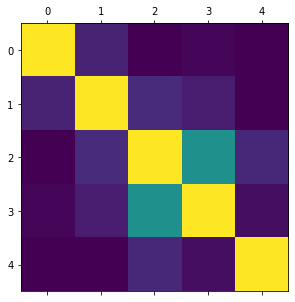

In [72]:
plt.matshow(df_sub[['falgIRQ_mean', 'flagUS_mean', 'uniformed_mean', 'firearm_mean', 'militaryVehicle_mean']].corr())
plt.show()

In [83]:
X = df_sub.loc[:,['falgIRQ_mean', 'flagUS_mean', 'uniformed_mean', 'firearm_mean', 'militaryVehicle_mean']] # raw is ref
y = df_sub.loc[:, 'log_best']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

Dep. Variable:,log_best,R-squared:,0.0002
Estimator:,PanelOLS,R-squared (Between):,0.0010
No. Observations:,126548,R-squared (Within):,0.0003
Date:,"Tue, Oct 04 2022",R-squared (Overall):,0.0005
Time:,22:20:03,Log-likelihood,-3673.6
Cov. Estimator:,Clustered,,
,,F-statistic:,6.2405
Entities:,23,P-value,0.0000
Avg Obs:,5502.1,Distribution:,"F(5,126473)"
Min Obs:,2.0000,,
Max Obs:,1.035e+05,F-statistic (robust):,0.7503


In [69]:
df_sub[df_sub['Raw'] == 1].shape

(121869, 33)

In [70]:
df_sub[df_sub['Submitted'] == 1].shape

(4224, 33)

In [66]:
X = df_sub.loc[:,['Submitted', 'person_mean']] # raw is ref
y = df_sub.loc[:, 'female_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

Dep. Variable:,female_mean,R-squared:,0.2536
Estimator:,PanelOLS,R-squared (Between):,0.7249
No. Observations:,126548,R-squared (Within):,0.2578
Date:,"Tue, Oct 04 2022",R-squared (Overall):,0.5265
Time:,22:07:20,Log-likelihood,-1.454e+05
Cov. Estimator:,Clustered,,
,,F-statistic:,2.149e+04
Entities:,23,P-value,0.0000
Avg Obs:,5502.1,Distribution:,"F(2,126476)"
Min Obs:,2.0000,,
Max Obs:,1.035e+05,F-statistic (robust):,1848.2


In [68]:
X = df_sub.loc[:,['Raw']] # raw is ref
y = df_sub.loc[:, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

Dep. Variable:,religiousGarmentFemale_mean,R-squared:,0.0003
Estimator:,PanelOLS,R-squared (Between):,-0.1356
No. Observations:,126548,R-squared (Within):,0.0003
Date:,"Tue, Oct 04 2022",R-squared (Overall):,-0.0694
Time:,22:09:08,Log-likelihood,-4.371e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,38.815
Entities:,23,P-value,0.0000
Avg Obs:,5502.1,Distribution:,"F(1,126477)"
Min Obs:,2.0000,,
Max Obs:,1.035e+05,F-statistic (robust):,35.303


In [12]:
df_sub

person_mean  child_mean  male_mean  adult_mean  youth_mean  \
gid    month_id                                                               
177569 348               3.0         0.0        3.4         2.8         0.0   
       357               3.0         0.0        1.4         1.2         0.0   
       334               1.6         0.0        1.6         2.4         0.0   
179003 311               2.8         0.0        1.4         1.8         0.0   
       311               1.8         0.0        1.4         1.8         0.0   
...                      ...         ...        ...         ...         ...   
179009 289               2.8         1.5        1.8         2.4         1.0   
       289               0.6         0.0        0.2         0.2         0.0   
       289               2.0         0.0        2.0         1.8         0.0   
       289               4.8         1.5        4.0         4.6         0.5   
       289               6.8         0.5        4.2         5.2         0.5   

                 falgIRQ_mean  female_mean  religiousGarmentFemale_mean  \
gid    month_id                                                           
177569 348                0.0          0.0                          0.0   
       357                0.0          0.0                          0.0   
       334                0.0          0.0                          0.0   
179003 311                0.8          0.0                          0.0   
       311                0.0          0.5                          0.0   
...                       ...          ...                          ...   
179009 289                0.0          0.5                          0.0   
       289                0.0          0.0                          0.0   
       289                0.0          1.0                          0.0   
       289                0.0          0.5                          0.0   
       289                0.0          0.5                          0.0   

                 uniformed_mean  firearm_mean  ...  ttime_mean  log_best  \
gid    month_id                                ...                         
177569 348                  0.2           0.0  ...    58.67639  1.791759   
       357                  2.6           0.0  ...    58.67639  1.791759   
       334                  0.6           0.0  ...    58.67639  3.367296   
179003 311                  2.4           0.0  ...   415.26140  4.941642   
       311                  0.0           0.0  ...   415.26140  4.941642   
...                         ...           ...  ...         ...       ...   
179009 289                  0.0           0.2  ...   168.32170  0.000000   
       289                  0.6           0.0  ...   168.32170  0.000000   
       289                  0.4           0.0  ...   168.32170  0.000000   
       289                  0.0           0.0  ...   168.32170  0.000000   
       289                  4.2           1.0  ...   168.32170  0.000000   

                      tce      tsce  Published  Raw  Submitted  intPubBest  \
gid    month_id                                                              
177569 348       1.956879  1.051318          0    1          0         0.0   
       357       2.914739  1.355943          0    1          0         0.0   
       334       3.367234  1.978720          0    1          0         0.0   
179003 311       3.018411  1.516200          0    1          0         0.0   
       311       3.018411  1.516200          0    1          0         0.0   
...                   ...       ...        ...  ...        ...         ...   
179009 289      -0.022490 -0.016555          0    0          1         0.0   
       289      -0.022490 -0.016555          0    0          1         0.0   
       289      -0.022490 -0.016555          0    0          1         0.0   
       289      -0.022490 -0.016555          0    0          1         0.0   
       289      -0.022490 -0.016555          0    0          1         0.0   

         

In [18]:
bodies_df_exposure['gid'].unique().shape[0] 

23

In [17]:
bodies_df_exposure['gid'].unique().shape[0] * bodies_df_exposure['month_id'].unique().shape[0]

1150

In [21]:
bodies_df_exposure['month_id'].unique()

array([348, 357, 334, 311, 316, 349, 326, 281, 322, 324, 333, 314, 306,
       315, 312, 307, 303, 331, 304, 356, 308, 313, 330, 321, 288, 358,
       336, 280, 332, 279, 310, 305, 325, 289, 335, 359, 350, 338, 292,
       320, 345, 352, 241, 361, 300, 294, 257, 282, 327, 299])

# Old ish

# NOTES:


RQ:
- To what extent does the distribution of content in the images, differs across publication status.
 
- To What extent does the distribution of content in the images corrolate with the magnitude/exposure of conflict 


In [3]:
# pre

list_of_features_mean = [feature for feature in bodies_df_exposure.columns if 'mean' in feature] 

df_sub = bodies_df_exposure[list_of_features_mean + ['log_best', 'tce', 'tsce', 'publication', 'month_id', 'gid']].copy()
df_sub = df_sub[df_sub['person_mean'] != 0] # no people, no entry
df_sub[['Published', 'Raw', 'Submitted']] = pd.get_dummies(df_sub[['publication']])
df_sub.drop(columns= 'publication', inplace= True)
df_sub.dropna(inplace= True)
df_sub.set_index(['gid', 'month_id'], inplace = True)
df_sub['intPubBest'] = df_sub['Published'] * df_sub['log_best']
df_sub['intPubTce'] = df_sub['Published'] * df_sub['tce']
df_sub['intPubTsce'] = df_sub['Published'] * df_sub['tsce']


# also drop all with no persons in them

# gender
## Contiues dependents:

$$
female_{it} = \alpha_{i} + \gamma_{t} + \beta_{1} logConflict_{it} + \beta_{2} published_{it} + \beta_{3} submitted_{it} + \beta_{4} persons_{it} + \epsilon_{it}   
$$

Interestingly, the results holds is we have male mean as dependent. I.e. then Published is significantly negativly corrolated with published 


In [4]:
X = df_sub.loc[:,['log_best', 'Published', 'Submitted', 'person_mean']] # raw is ref
y = df_sub.loc[:, 'female_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

Dep. Variable:,female_mean,R-squared:,0.2542
Estimator:,PanelOLS,R-squared (Between):,0.7204
No. Observations:,126548,R-squared (Within):,0.2526
Date:,"Mon, Sep 19 2022",R-squared (Overall):,0.4840
Time:,13:23:08,Log-likelihood,-1.454e+05
Cov. Estimator:,Clustered,,
,,F-statistic:,1.078e+04
Entities:,23,P-value,0.0000
Avg Obs:,5502.1,Distribution:,"F(4,126474)"
Min Obs:,2.0000,,
Max Obs:,1.035e+05,F-statistic (robust):,-2.909e+18


$$
male_{it} = \alpha_{i} + \gamma_{t} + \beta_{1} tce_{it} + \beta_{2} published_{it} + \beta_{3} submitted_{it} + \beta_{4} persons_{it} + \epsilon_{it}   
$$


In [5]:
X = df_sub.loc[:,['log_best', 'Published', 'Submitted', 'person_mean']] # raw is ref
y = df_sub.loc[:, 'male_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

Dep. Variable:,male_mean,R-squared:,0.8761
Estimator:,PanelOLS,R-squared (Between):,0.9647
No. Observations:,126548,R-squared (Within):,0.8762
Date:,"Mon, Sep 19 2022",R-squared (Overall):,0.9278
Time:,13:23:11,Log-likelihood,-1.633e+05
Cov. Estimator:,Clustered,,
,,F-statistic:,2.235e+05
Entities:,23,P-value,0.0000
Avg Obs:,5502.1,Distribution:,"F(4,126474)"
Min Obs:,2.0000,,
Max Obs:,1.035e+05,F-statistic (robust):,9.185e+18



$$
female_{it} = \alpha_{i} + \gamma_{t} + \beta_{1} tce_{it} + \beta_{2} published_{it} + \beta_{3} submitted_{it} + \beta_{4} persons_{it} + \epsilon_{it}   
$$


In [6]:
X = df_sub.loc[:,['tce', 'Published', 'Submitted', 'person_mean']] # raw is ref
y = df_sub.loc[:, 'female_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

Dep. Variable:,female_mean,R-squared:,0.2545
Estimator:,PanelOLS,R-squared (Between):,0.7171
No. Observations:,126548,R-squared (Within):,0.2624
Date:,"Mon, Sep 19 2022",R-squared (Overall):,0.5364
Time:,13:23:13,Log-likelihood,-1.453e+05
Cov. Estimator:,Clustered,,
,,F-statistic:,1.079e+04
Entities:,23,P-value,0.0000
Avg Obs:,5502.1,Distribution:,"F(4,126474)"
Min Obs:,2.0000,,
Max Obs:,1.035e+05,F-statistic (robust):,-8.728e+18


In [7]:
X = df_sub.loc[:,['tce', 'Published', 'Submitted', 'person_mean']] # raw is ref
y = df_sub.loc[:, 'male_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

Dep. Variable:,male_mean,R-squared:,0.8761
Estimator:,PanelOLS,R-squared (Between):,0.9604
No. Observations:,126548,R-squared (Within):,0.8762
Date:,"Mon, Sep 19 2022",R-squared (Overall):,0.9191
Time:,13:23:15,Log-likelihood,-1.633e+05
Cov. Estimator:,Clustered,,
,,F-statistic:,2.235e+05
Entities:,23,P-value,0.0000
Avg Obs:,5502.1,Distribution:,"F(4,126474)"
Min Obs:,2.0000,,
Max Obs:,1.035e+05,F-statistic (robust):,4.593e+18



$$
female_{it} = \alpha_{i} + \gamma_{t} + \beta_{1} tsce_{it} + \beta_{2} published_{it} + \beta_{3} submitted_{it} + \beta_{4} persons_{it} + \epsilon_{it}   
$$


In [8]:
X = df_sub.loc[:,['tsce', 'Published', 'Submitted', 'person_mean']] # raw is ref
y = df_sub.loc[:, 'female_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

Dep. Variable:,female_mean,R-squared:,0.2544
Estimator:,PanelOLS,R-squared (Between):,0.7217
No. Observations:,126548,R-squared (Within):,0.2610
Date:,"Mon, Sep 19 2022",R-squared (Overall):,0.5315
Time:,13:23:17,Log-likelihood,-1.453e+05
Cov. Estimator:,Clustered,,
,,F-statistic:,1.079e+04
Entities:,23,P-value,0.0000
Avg Obs:,5502.1,Distribution:,"F(4,126474)"
Min Obs:,2.0000,,
Max Obs:,1.035e+05,F-statistic (robust):,-8.728e+18



$$
female_{it} = \alpha_{i} + \gamma_{t} + \beta_{1} tsce_{it} + \beta_{2} published_{it} + \beta_{3} submitted_{it} + \beta_{4} persons_{it} + \epsilon_{it}   
$$


In [9]:
X = df_sub.loc[:,['tsce', 'Published', 'Submitted', 'person_mean']] # raw is ref
y = df_sub.loc[:, 'male_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

Dep. Variable:,male_mean,R-squared:,0.8761
Estimator:,PanelOLS,R-squared (Between):,0.9609
No. Observations:,126548,R-squared (Within):,0.8763
Date:,"Mon, Sep 19 2022",R-squared (Overall):,0.9202
Time:,13:23:19,Log-likelihood,-1.633e+05
Cov. Estimator:,Clustered,,
,,F-statistic:,2.235e+05
Entities:,23,P-value,0.0000
Avg Obs:,5502.1,Distribution:,"F(4,126474)"
Min Obs:,2.0000,,
Max Obs:,1.035e+05,F-statistic (robust):,9.185e+18


$$
religiousGarments_{it} =  \alpha_{i} + \gamma_{t} + \beta_{1} logConflict_{it} + \beta_{2} published_{it} + \beta_{3} submitted_{it} + \beta_{4} persons_{it} + \beta_{5} female_{it} + \epsilon_{it}  
$$

In [10]:
X = df_sub.loc[:,['female_mean', 'log_best', 'Published', 'Submitted']] # raw is ref
y = df_sub.loc[:, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed=True)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

Dep. Variable:,religiousGarmentFemale_mean,R-squared:,0.3404
Estimator:,PanelOLS,R-squared (Between):,0.9104
No. Observations:,126548,R-squared (Within):,0.3517
Date:,"Mon, Sep 19 2022",R-squared (Overall):,0.4274
Time:,13:23:21,Log-likelihood,-1.74e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,1.632e+04
Entities:,23,P-value,0.0000
Avg Obs:,5502.1,Distribution:,"F(4,126474)"
Min Obs:,2.0000,,
Max Obs:,1.035e+05,F-statistic (robust):,4.465e+19


$$
religiousGarments_{it} =  \alpha_{i} + \gamma_{t} + \beta_{1} tce_{it} + \beta_{2} published_{it} + \beta_{3} submitted_{it} + \beta_{4} persons_{it} + \beta_{5} female_{it} + \epsilon_{it}  
$$

In [11]:
X = df_sub.loc[:,['female_mean', 'tce', 'Published', 'Submitted']] # raw is ref
y = df_sub.loc[:, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed=True)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

Dep. Variable:,religiousGarmentFemale_mean,R-squared:,0.3407
Estimator:,PanelOLS,R-squared (Between):,0.8938
No. Observations:,126548,R-squared (Within):,0.3500
Date:,"Mon, Sep 19 2022",R-squared (Overall):,0.3711
Time:,13:23:23,Log-likelihood,-1.738e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,1.634e+04
Entities:,23,P-value,0.0000
Avg Obs:,5502.1,Distribution:,"F(4,126474)"
Min Obs:,2.0000,,
Max Obs:,1.035e+05,F-statistic (robust):,8.726e+19


$$
religiousGarments_{it} =  \alpha_{i} + \gamma_{t} + \beta_{1} tsce_{it} + \beta_{2} published_{it} + \beta_{3} submitted_{it} + \beta_{4} persons_{it} + \beta_{5} female_{it} + \epsilon_{it}  
$$

# with interactions

In [12]:
X = df_sub.loc[:,['log_best', 'intPubBest', 'Published', 'Submitted', 'person_mean']] # raw is ref
y = df_sub.loc[:, 'female_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

/tmp/ipykernel_179252/2099713059.py:12: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

Published

  m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)


Dep. Variable:,female_mean,R-squared:,0.2542
Estimator:,PanelOLS,R-squared (Between):,0.7204
No. Observations:,126548,R-squared (Within):,0.2526
Date:,"Mon, Sep 19 2022",R-squared (Overall):,0.4839
Time:,13:23:25,Log-likelihood,-1.454e+05
Cov. Estimator:,Clustered,,
,,F-statistic:,1.078e+04
Entities:,23,P-value,0.0000
Avg Obs:,5502.1,Distribution:,"F(4,126474)"
Min Obs:,2.0000,,
Max Obs:,1.035e+05,F-statistic (robust):,-2.099e+18


In [13]:
X = df_sub.loc[:,['tce', 'intPubTce', 'Published', 'Submitted', 'person_mean']] # raw is ref
y = df_sub.loc[:, 'female_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

/tmp/ipykernel_179252/1668388244.py:12: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

Published

  m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)


Dep. Variable:,female_mean,R-squared:,0.2545
Estimator:,PanelOLS,R-squared (Between):,0.7171
No. Observations:,126548,R-squared (Within):,0.2624
Date:,"Mon, Sep 19 2022",R-squared (Overall):,0.5364
Time:,13:23:28,Log-likelihood,-1.453e+05
Cov. Estimator:,Clustered,,
,,F-statistic:,1.079e+04
Entities:,23,P-value,0.0000
Avg Obs:,5502.1,Distribution:,"F(4,126474)"
Min Obs:,2.0000,,
Max Obs:,1.035e+05,F-statistic (robust):,9.396e+18


In [14]:
X = df_sub.loc[:,['tsce', 'intPubTsce', 'Published', 'Submitted', 'person_mean']] # raw is ref
y = df_sub.loc[:, 'female_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

/tmp/ipykernel_179252/3023179014.py:12: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

Published

  m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)


Dep. Variable:,female_mean,R-squared:,0.2544
Estimator:,PanelOLS,R-squared (Between):,0.7217
No. Observations:,126548,R-squared (Within):,0.2610
Date:,"Mon, Sep 19 2022",R-squared (Overall):,0.5315
Time:,13:23:30,Log-likelihood,-1.453e+05
Cov. Estimator:,Clustered,,
,,F-statistic:,1.079e+04
Entities:,23,P-value,0.0000
Avg Obs:,5502.1,Distribution:,"F(4,126474)"
Min Obs:,2.0000,,
Max Obs:,1.035e+05,F-statistic (robust):,2.889e+18


In [15]:
X = df_sub.loc[:,['female_mean', 'log_best', 'intPubBest', 'Published', 'Submitted']] # raw is ref
y = df_sub.loc[:, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed=True)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

/tmp/ipykernel_179252/2186205462.py:10: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

Published

  m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)


Dep. Variable:,religiousGarmentFemale_mean,R-squared:,0.3404
Estimator:,PanelOLS,R-squared (Between):,0.9104
No. Observations:,126548,R-squared (Within):,0.3517
Date:,"Mon, Sep 19 2022",R-squared (Overall):,0.4274
Time:,13:23:33,Log-likelihood,-1.74e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,1.632e+04
Entities:,23,P-value,0.0000
Avg Obs:,5502.1,Distribution:,"F(4,126474)"
Min Obs:,2.0000,,
Max Obs:,1.035e+05,F-statistic (robust):,-3.426e+19


In [16]:
X = df_sub.loc[:,['female_mean', 'tce', 'intPubTce', 'Published', 'Submitted']] # raw is ref
y = df_sub.loc[:, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed=True)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

/tmp/ipykernel_179252/1318747554.py:10: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

Published

  m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)


Dep. Variable:,religiousGarmentFemale_mean,R-squared:,0.3407
Estimator:,PanelOLS,R-squared (Between):,0.8938
No. Observations:,126548,R-squared (Within):,0.3500
Date:,"Mon, Sep 19 2022",R-squared (Overall):,0.3711
Time:,13:23:35,Log-likelihood,-1.738e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,1.634e+04
Entities:,23,P-value,0.0000
Avg Obs:,5502.1,Distribution:,"F(4,126474)"
Min Obs:,2.0000,,
Max Obs:,1.035e+05,F-statistic (robust):,-5.157e+19


In [17]:
X = df_sub.loc[:,['female_mean', 'tsce', 'intPubTsce', 'Published', 'Submitted']] # raw is ref
y = df_sub.loc[:, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed=True)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

/tmp/ipykernel_179252/3981241453.py:10: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

Published

  m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)


Dep. Variable:,religiousGarmentFemale_mean,R-squared:,0.3406
Estimator:,PanelOLS,R-squared (Between):,0.8821
No. Observations:,126548,R-squared (Within):,0.3485
Date:,"Mon, Sep 19 2022",R-squared (Overall):,0.3595
Time:,13:23:38,Log-likelihood,-1.738e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,1.633e+04
Entities:,23,P-value,0.0000
Avg Obs:,5502.1,Distribution:,"F(4,126474)"
Min Obs:,2.0000,,
Max Obs:,1.035e+05,F-statistic (robust):,7.339e+19


### Binary dependent (linar probability model)

$$
binaryFemale_{it} = \alpha_{i} + \gamma_{t} + \beta_{1} logConflict_{it} + \beta_{2} published_{it} + \beta_{3} submitted_{it} + \beta_{4} persons_{it} + \epsilon_{it}   
$$

$$
binaryFeligiousGarments_{it} =  \gamma_{i} + \alpha_{t} + \beta_{1} logConflict_{it} + \beta_{2} published_{it} + \beta_{3} submitted_{it} + \beta_{4} persons_{it} + \beta_{5} female_{it} + \epsilon_{it}  
$$

In [18]:
X = df_sub.loc[:,['log_best', 'person_mean', 'Published', 'Submitted']] # raw is ref
y = (df_sub.loc[:, 'female_mean'] > 0).astype(int)


m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

Dep. Variable:,female_mean,R-squared:,0.0758
Estimator:,PanelOLS,R-squared (Between):,0.4731
No. Observations:,126548,R-squared (Within):,0.0772
Date:,"Mon, Sep 19 2022",R-squared (Overall):,0.2993
Time:,13:23:41,Log-likelihood,-8.038e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,2593.7
Entities:,23,P-value,0.0000
Avg Obs:,5502.1,Distribution:,"F(4,126474)"
Min Obs:,2.0000,,
Max Obs:,1.035e+05,F-statistic (robust):,-2.646e+17


In [19]:
X = df_sub.loc[:,['female_mean', 'person_mean', 'log_best', 'Published', 'Submitted']] # raw is ref
y = (df_sub.loc[:, 'religiousGarmentFemale_mean'] > 0).astype(int)

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

/home/simon/anaconda3/envs/scikit_env/lib/python3.8/site-packages/linearmodels/panel/results.py:87: RuntimeWarning: invalid value encountered in sqrt
  return Series(np.sqrt(np.diag(self.cov)), self._var_names, name="std_error")
/home/simon/anaconda3/envs/scikit_env/lib/python3.8/site-packages/linearmodels/panel/results.py:87: RuntimeWarning: invalid value encountered in sqrt
  return Series(np.sqrt(np.diag(self.cov)), self._var_names, name="std_error")
/home/simon/anaconda3/envs/scikit_env/lib/python3.8/site-packages/linearmodels/panel/results.py:87: RuntimeWarning: invalid value encountered in sqrt
  return Series(np.sqrt(np.diag(self.cov)), self._var_names, name="std_error")
/home/simon/anaconda3/envs/scikit_env/lib/python3.8/site-packages/linearmodels/panel/results.py:87: RuntimeWarning: invalid value encountered in sqrt
  return Series(np.sqrt(np.diag(self.cov)), self._var_names, name="std_error")
/home/simon/anaconda3/envs/scikit_env/lib/python3.8/site-packages/linearmodels/panel

Dep. Variable:,religiousGarmentFemale_mean,R-squared:,0.2533
Estimator:,PanelOLS,R-squared (Between):,0.8558
No. Observations:,126548,R-squared (Within):,0.2663
Date:,"Mon, Sep 19 2022",R-squared (Overall):,0.4119
Time:,13:23:43,Log-likelihood,-4.076e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,8579.7
Entities:,23,P-value,0.0000
Avg Obs:,5502.1,Distribution:,"F(5,126473)"
Min Obs:,2.0000,,
Max Obs:,1.035e+05,F-statistic (robust):,2.445e+20


## Logged dependent

$$
logFemale_{it} = \alpha_{i} + \gamma_{t} + \beta_{1} logConflict_{it} + \beta_{2} published_{it} + \beta_{3} submitted_{it} + \beta_{4} persons_{it} + \epsilon_{it}   
$$

$$
logFeligiousGarments_{it} =  \alpha_{i} + \gamma_{t} + \beta_{1} logConflict_{it} + \beta_{2} published_{it} + \beta_{3} submitted_{it} + \beta_{4} persons_{it} + \beta_{5} female_{it} + \epsilon_{it}  
$$

In [20]:
X = df_sub.loc[:,['log_best', 'person_mean', 'Published', 'Submitted']] # raw is ref
y = np.log(df_sub.loc[:, 'female_mean']+1)


m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

Dep. Variable:,female_mean,R-squared:,0.2046
Estimator:,PanelOLS,R-squared (Between):,0.7023
No. Observations:,126548,R-squared (Within):,0.2032
Date:,"Mon, Sep 19 2022",R-squared (Overall):,0.4531
Time:,13:23:45,Log-likelihood,-5.737e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,8133.4
Entities:,23,P-value,0.0000
Avg Obs:,5502.1,Distribution:,"F(4,126474)"
Min Obs:,2.0000,,
Max Obs:,1.035e+05,F-statistic (robust):,7.965e+19


In [21]:
X = df_sub.loc[:,['female_mean', 'person_mean', 'log_best', 'Published', 'Submitted']] # raw is ref
y = np.log(df_sub.loc[:, 'religiousGarmentFemale_mean'] + 1)

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

/home/simon/anaconda3/envs/scikit_env/lib/python3.8/site-packages/linearmodels/panel/results.py:87: RuntimeWarning: invalid value encountered in sqrt
  return Series(np.sqrt(np.diag(self.cov)), self._var_names, name="std_error")
/home/simon/anaconda3/envs/scikit_env/lib/python3.8/site-packages/linearmodels/panel/results.py:87: RuntimeWarning: invalid value encountered in sqrt
  return Series(np.sqrt(np.diag(self.cov)), self._var_names, name="std_error")
/home/simon/anaconda3/envs/scikit_env/lib/python3.8/site-packages/linearmodels/panel/results.py:87: RuntimeWarning: invalid value encountered in sqrt
  return Series(np.sqrt(np.diag(self.cov)), self._var_names, name="std_error")
/home/simon/anaconda3/envs/scikit_env/lib/python3.8/site-packages/linearmodels/panel/results.py:87: RuntimeWarning: invalid value encountered in sqrt
  return Series(np.sqrt(np.diag(self.cov)), self._var_names, name="std_error")
/home/simon/anaconda3/envs/scikit_env/lib/python3.8/site-packages/linearmodels/panel

Dep. Variable:,religiousGarmentFemale_mean,R-squared:,0.3339
Estimator:,PanelOLS,R-squared (Between):,0.9286
No. Observations:,126548,R-squared (Within):,0.3463
Date:,"Mon, Sep 19 2022",R-squared (Overall):,0.4581
Time:,13:23:48,Log-likelihood,3.722e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,1.268e+04
Entities:,23,P-value,0.0000
Avg Obs:,5502.1,Distribution:,"F(5,126473)"
Min Obs:,2.0000,,
Max Obs:,1.035e+05,F-statistic (robust):,9.003e+19


## ratio dependent

$$
ratioFemalePerson_{it} = \alpha_{i} + \gamma_{t} + \beta_{1} logConflict_{it} + \beta_{2} published_{it} + \beta_{3} submitted_{it} + \beta_{4} persons_{it} + \epsilon_{it}   
$$

$$
ratioFemaleReligiousGarments_{it} =  \alpha_{i} + \gamma_{t} + \beta_{1} logConflict_{it} + \beta_{2} published_{it} + \beta_{3} submitted_{it} + \beta_{4} persons_{it} + \beta_{5} + female_{it} \epsilon_{it}  
$$

In [22]:
X = df_sub.loc[:,['log_best', 'person_mean', 'Published', 'Submitted']] # raw is ref
y = df_sub.loc[:, 'female_mean']/df_sub.loc[:, 'person_mean']


m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

Dep. Variable:,0,R-squared:,0.0070
Estimator:,PanelOLS,R-squared (Between):,-0.1795
No. Observations:,126548,R-squared (Within):,0.0074
Date:,"Mon, Sep 19 2022",R-squared (Overall):,-0.0866
Time:,13:23:50,Log-likelihood,-4.297e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,222.22
Entities:,23,P-value,0.0000
Avg Obs:,5502.1,Distribution:,"F(4,126474)"
Min Obs:,2.0000,,
Max Obs:,1.035e+05,F-statistic (robust):,-9.783e+18


In [23]:
df_sub_fem = df_sub[df_sub['female_mean']>0].copy()

X = df_sub_fem.loc[:,['female_mean', 'person_mean', 'log_best', 'Published', 'Submitted']] # raw is ref
y = df_sub_fem.loc[:, 'religiousGarmentFemale_mean']/df_sub_fem.loc[:, 'female_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

Dep. Variable:,0,R-squared:,0.0111
Estimator:,PanelOLS,R-squared (Between):,0.2531
No. Observations:,72153,R-squared (Within):,0.0061
Date:,"Mon, Sep 19 2022",R-squared (Overall):,0.1782
Time:,13:23:51,Log-likelihood,-1.576e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,161.68
Entities:,23,P-value,0.0000
Avg Obs:,3137.1,Distribution:,"F(5,72082)"
Min Obs:,0.0000,,
Max Obs:,6.138e+04,F-statistic (robust):,7.842e+19


Conflict
...

In [24]:
X = df_sub.loc[:, list_of_features_mean] # raw is ref
y = df_sub.loc[:, 'log_best']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

ValueError: exog does not have full column rank. If you wish to proceed with model estimation irrespective of the numerical accuracy of coefficient estimates, you can set check_rank=False.

In [ ]:
X = df_sub.loc[:, list_of_features_mean] # raw is ref
y = df_sub.loc[:, 'tce']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

Dep. Variable:,tce,R-squared:,0.0056
Estimator:,PanelOLS,R-squared (Between):,-0.0105
No. Observations:,126548,R-squared (Within):,-0.0003
Date:,"Thu, Jun 30 2022",R-squared (Overall):,-0.0065
Time:,00:11:30,Log-likelihood,1.443e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,44.391
Entities:,23,P-value,0.0000
Avg Obs:,5502.1,Distribution:,"F(16,126462)"
Min Obs:,2.0000,,
Max Obs:,1.035e+05,F-statistic (robust):,0.1840


In [ ]:

X = df_sub.loc[:, list_of_features_mean + ['Published', 'Submitted']] # raw is ref
y = df_sub.loc[:, 'tsce']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

Dep. Variable:,tsce,R-squared:,0.0055
Estimator:,PanelOLS,R-squared (Between):,-0.0058
No. Observations:,126548,R-squared (Within):,-0.0003
Date:,"Thu, Jun 30 2022",R-squared (Overall):,-0.0053
Time:,00:17:32,Log-likelihood,1.17e+05
Cov. Estimator:,Clustered,,
,,F-statistic:,39.208
Entities:,23,P-value,0.0000
Avg Obs:,5502.1,Distribution:,"F(18,126460)"
Min Obs:,2.0000,,
Max Obs:,1.035e+05,F-statistic (robust):,0.6207


In [ ]:

X = df_sub.loc[:, ['religiousGarmentFemale_mean']] # raw is ref
y = df_sub.loc[:, 'tsce']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

Dep. Variable:,tsce,R-squared:,0.0004
Estimator:,PanelOLS,R-squared (Between):,0.0013
No. Observations:,126548,R-squared (Within):,0.0003
Date:,"Thu, Jun 30 2022",R-squared (Overall):,0.0008
Time:,00:16:36,Log-likelihood,1.167e+05
Cov. Estimator:,Clustered,,
,,F-statistic:,47.474
Entities:,23,P-value,0.0000
Avg Obs:,5502.1,Distribution:,"F(1,126477)"
Min Obs:,2.0000,,
Max Obs:,1.035e+05,F-statistic (robust):,0.8739


In [ ]:

df_sub['intTsceFemale'] = df_sub.loc[:,'tsce']  * df_sub.loc[:,'female_mean'] 


X = df_sub.loc[:, ['tsce', 'female_mean', 'intTsceFemale']] # raw is ref
y = df_sub.loc[:, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

Dep. Variable:,religiousGarmentFemale_mean,R-squared:,0.3402
Estimator:,PanelOLS,R-squared (Between):,0.8813
No. Observations:,126548,R-squared (Within):,0.3476
Date:,"Thu, Jun 30 2022",R-squared (Overall):,0.3385
Time:,00:26:38,Log-likelihood,-1.742e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,2.173e+04
Entities:,23,P-value,0.0000
Avg Obs:,5502.1,Distribution:,"F(3,126475)"
Min Obs:,2.0000,,
Max Obs:,1.035e+05,F-statistic (robust):,1710.4


In [ ]:
df_sub_fem = df_sub[df_sub['female_mean']>0].copy()

df_sub_fem['intTsceFemale'] = df_sub_fem.loc[:,'tsce']  * df_sub_fem.loc[:,'female_mean'] 

X = df_sub_fem.loc[:,['female_mean', 'tsce', 'intTsceFemale']] # raw is ref
y = df_sub_fem.loc[:, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

Dep. Variable:,religiousGarmentFemale_mean,R-squared:,0.2802
Estimator:,PanelOLS,R-squared (Between):,0.7057
No. Observations:,72153,R-squared (Within):,0.2747
Date:,"Thu, Jun 30 2022",R-squared (Overall):,0.1090
Time:,00:22:59,Log-likelihood,-2.898e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,9355.0
Entities:,23,P-value,0.0000
Avg Obs:,3137.1,Distribution:,"F(3,72084)"
Min Obs:,0.0000,,
Max Obs:,6.138e+04,F-statistic (robust):,1790.7


In [ ]:
X = df_sub.loc[:, ['tsce', 'person_mean', 'Published', 'Submitted']] # raw is ref
y = df_sub.loc[:, 'male_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

Dep. Variable:,male_mean,R-squared:,0.8761
Estimator:,PanelOLS,R-squared (Between):,0.9593
No. Observations:,126548,R-squared (Within):,0.8761
Date:,"Thu, Jun 30 2022",R-squared (Overall):,0.9168
Time:,01:04:24,Log-likelihood,-1.633e+05
Cov. Estimator:,Clustered,,
,,F-statistic:,2.235e+05
Entities:,23,P-value,0.0000
Avg Obs:,5502.1,Distribution:,"F(4,126474)"
Min Obs:,2.0000,,
Max Obs:,1.035e+05,F-statistic (robust):,-2.197e+18


In [ ]:
X = df_sub.loc[:, ['tsce', 'Published', 'Submitted']] # raw is ref
y = df_sub.loc[:, 'person_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

Dep. Variable:,person_mean,R-squared:,0.0012
Estimator:,PanelOLS,R-squared (Between):,-0.2378
No. Observations:,126548,R-squared (Within):,-0.0145
Date:,"Thu, Jun 30 2022",R-squared (Overall):,-0.5987
Time:,01:09:26,Log-likelihood,-2.696e+05
Cov. Estimator:,Clustered,,
,,F-statistic:,51.782
Entities:,23,P-value,0.0000
Avg Obs:,5502.1,Distribution:,"F(3,126475)"
Min Obs:,2.0000,,
Max Obs:,1.035e+05,F-statistic (robust):,-2.273e+24


In [ ]:
X = df_sub.loc[:, ['tsce', 'person_mean', 'Published', 'Submitted']] # raw is ref
y = df_sub.loc[:, 'militaryVehicle_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

Dep. Variable:,militaryVehicle_mean,R-squared:,0.0063
Estimator:,PanelOLS,R-squared (Between):,-0.0250
No. Observations:,126548,R-squared (Within):,0.0077
Date:,"Thu, Jun 30 2022",R-squared (Overall):,-0.0267
Time:,01:11:43,Log-likelihood,3.929e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,201.92
Entities:,23,P-value,0.0000
Avg Obs:,5502.1,Distribution:,"F(4,126474)"
Min Obs:,2.0000,,
Max Obs:,1.035e+05,F-statistic (robust):,3.265e+15


In [ ]:
list_of_features_mean

['person_mean',
 'child_mean',
 'male_mean',
 'adult_mean',
 'youth_mean',
 'falgIRQ_mean',
 'female_mean',
 'religiousGarmentFemale_mean',
 'uniformed_mean',
 'firearm_mean',
 'flagUS_mean',
 'bloodedArea_mean',
 'militaryVehicle_mean',
 'hostage_mean',
 'casualty_mean',
 'elderly_mean']

In [ ]:
X = df_sub.loc[:, ['female_mean', 'religiousGarmentFemale_mean', 'person_mean', 'male_mean']] # raw is ref
y = df_sub.loc[:, 'Published']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

Dep. Variable:,Published,R-squared:,0.0017
Estimator:,PanelOLS,R-squared (Between):,-2.0649
No. Observations:,126548,R-squared (Within):,0.0027
Date:,"Thu, Jun 30 2022",R-squared (Overall):,0.0008
Time:,00:52:35,Log-likelihood,1.852e+05
Cov. Estimator:,Clustered,,
,,F-statistic:,43.099
Entities:,23,P-value,0.0000
Avg Obs:,5502.1,Distribution:,"F(5,126473)"
Min Obs:,2.0000,,
Max Obs:,1.035e+05,F-statistic (robust):,-2.6569


# old

In [ ]:

fitted_dict = dict()

for i in list_of_features_mean:

    X = df_sub.loc[:,['log_best', 'Published', 'Submitted']] # raw is ref
    y = df_sub.loc[:, i]

    m = PanelOLS(dependent=y,
                exog=X,
                entity_effects=True,
                time_effects=True)

    fitted_dict[i] = m.fit(cov_type='clustered', cluster_entity=True)

In [ ]:
fitted_dict

LinAlgError: Singular matrix

In [ ]:
X = df_sub.loc[:,['female_mean', 'log_best', 'Published', 'Submitted']] # raw is ref
y = df_sub.loc[:, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True)

m.fit(cov_type='clustered', cluster_entity=True)

Dep. Variable:,religiousGarmentFemale_mean,R-squared:,0.3554
Estimator:,PanelOLS,R-squared (Between):,0.9075
No. Observations:,152188,R-squared (Within):,0.3676
Date:,"Mon, Jun 27 2022",R-squared (Overall):,0.4309
Time:,10:48:20,Log-likelihood,-7166.9
Cov. Estimator:,Clustered,,
,,F-statistic:,2.097e+04
Entities:,23,P-value,0.0000
Avg Obs:,6616.9,Distribution:,"F(4,152112)"
Min Obs:,2.0000,,
Max Obs:,1.234e+05,F-statistic (robust):,6.135e+21


In [ ]:
X = df_sub.loc[:,['female_mean', 'log_best', 'Published', 'Submitted']] # raw is ref
y = df_sub.loc[:, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True)

m.fit(cov_type='clustered', cluster_entity=True)

Dep. Variable:,religiousGarmentFemale_mean,R-squared:,0.3554
Estimator:,PanelOLS,R-squared (Between):,0.9075
No. Observations:,152188,R-squared (Within):,0.3676
Date:,"Mon, Jun 27 2022",R-squared (Overall):,0.4309
Time:,10:24:07,Log-likelihood,-7166.9
Cov. Estimator:,Clustered,,
,,F-statistic:,2.097e+04
Entities:,23,P-value,0.0000
Avg Obs:,6616.9,Distribution:,"F(4,152112)"
Min Obs:,2.0000,,
Max Obs:,1.234e+05,F-statistic (robust):,6.135e+21
